In [343]:
from imports import *


# machine learning
from scipy import stats
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import resample
from sklearn.base import clone
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, r2_score
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import lime

from lime.lime_tabular import LimeTabularExplainer

pd.options.display.max_columns = 100

# 1. Problem Statement and Research Question

Economic growth is traditionally understood to be driven by three fundamental factors: human capital, geography, and institutions. These drivers shape the trajectory of nations and are frequently studied in growth literature. Less explored, however, are the reasons why these three factors vary across countries. We hypothesize that people’s beliefs play a key role in economic development. Specifically, we argue that beliefs about trust, equality, work ethic, and religion influence the likelihood of countries to adopt democratic institutions. Value formation, after all, likely shapes citizens’ willingness to accept democracy. We expect to find that the aforementioned values are strongest in countries with democratic traditions and weakest in countries with autocratic traditions.

As such, our main research question is:

“What is the relationship between the moral values of a country — regarding trust, work ethic, religion, and equality — and the adoption of democratic institutions? What is the relative importance of each of these beliefs to constructing a working democracy?”


We use the World Values Survey (WVS), a dataset which provides survey data on peoples' beliefs, attitudes, and values across a large number of countries from 1995 to 2024, to start answering this question. We use this data to quantify the values of each country along the axes of trust, work ethic, religion, and equality over time. With this panel dataset, we then have the ability to explore the association between a country's values and their democracy index score (a score published by The Economist detailing how democratic a country is). Below is a flow chart explaining our process for answering this question.

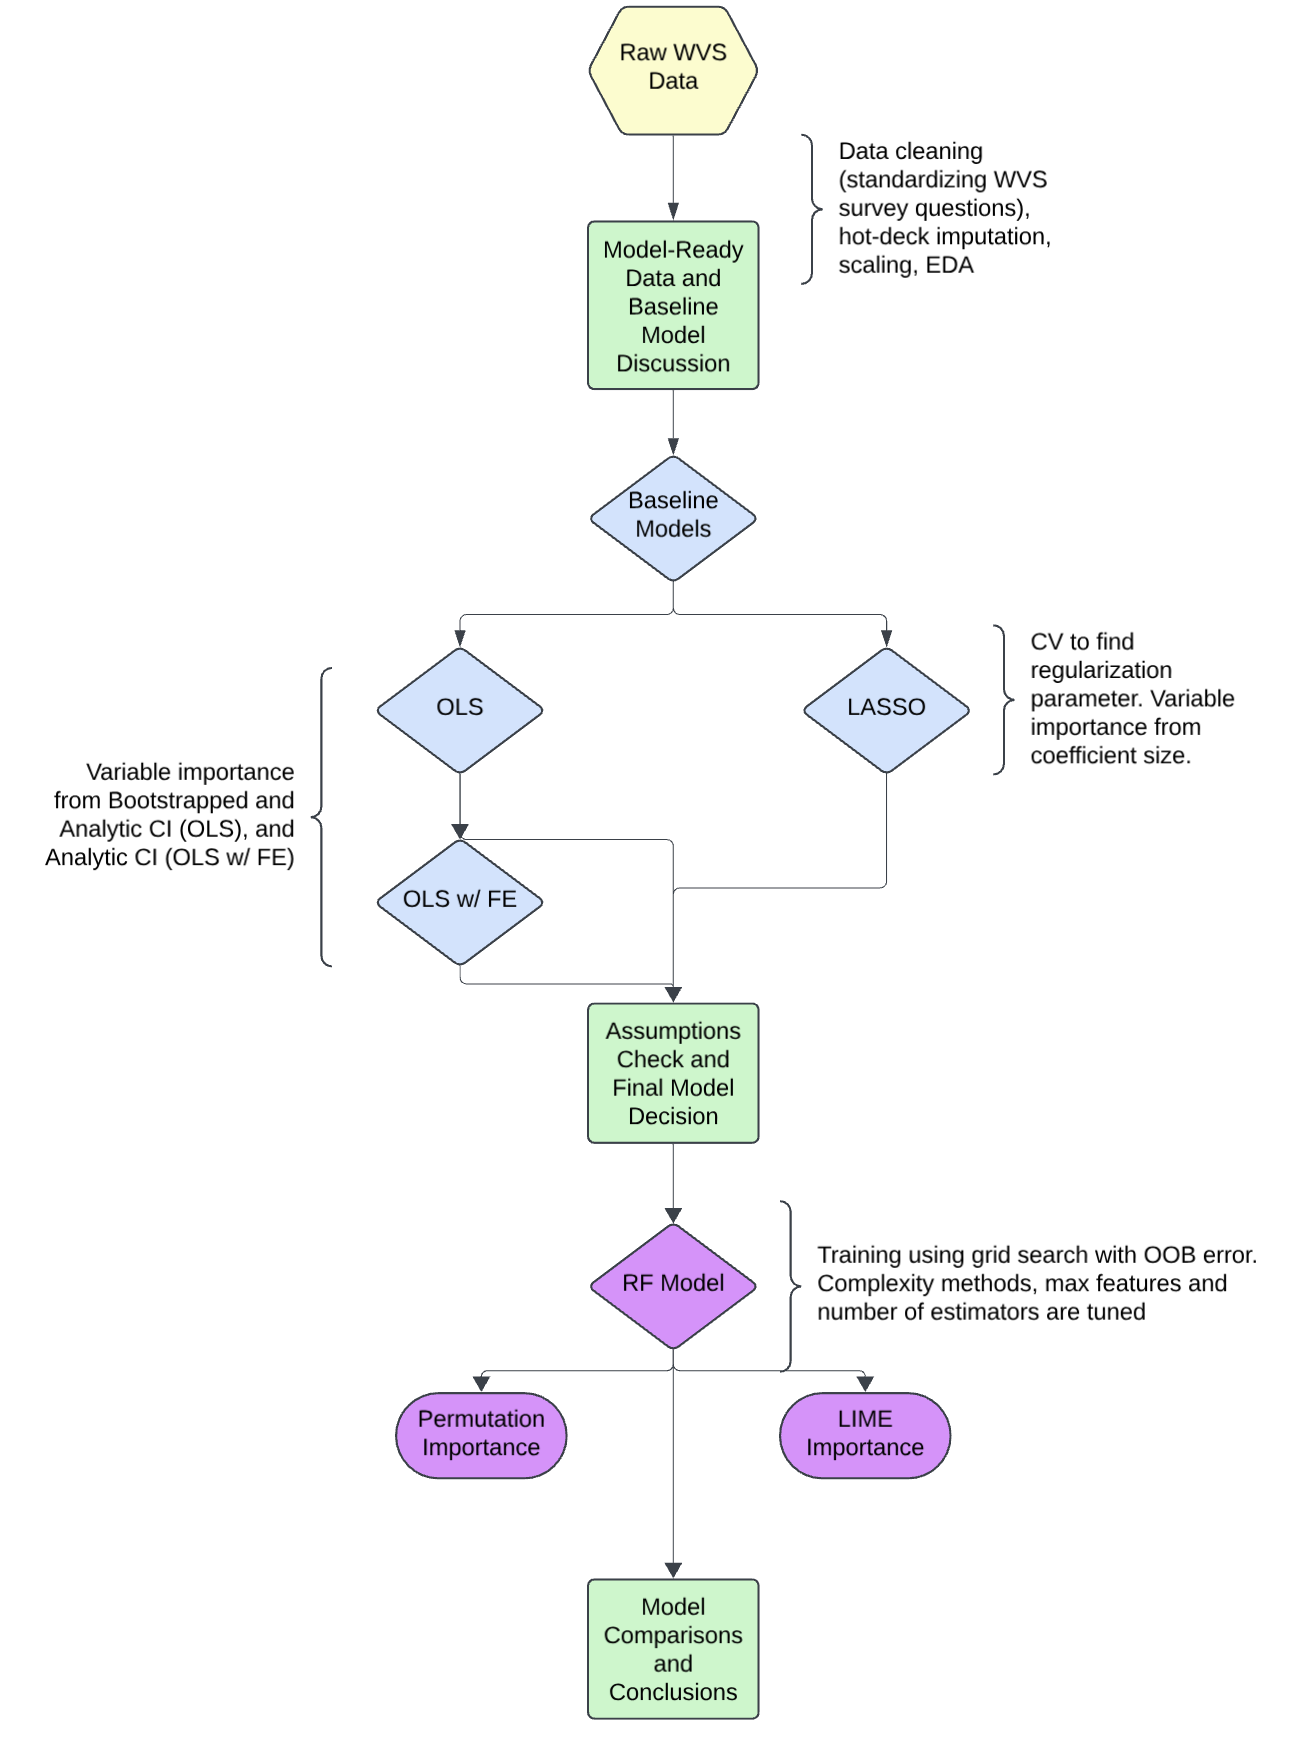

# 2. Exploring and Visualizing Data

In [344]:
df = pd.read_csv("cleaned_data/cleaned_wvs_data.csv")

## 2a. Initial Data Cleaning

We used four datasets for this project: the World Values Survey (WVS), the Economist's Democracy Index (as a response variable), the UN's GDP per capita time series, and the UN's Human Development Index (HDI). 

The WVS data set has longitudinal data from seven waves of cross-sectional surveys about citizens' values. Because Democracy Index has only been measured since 2006, we had to limit our analysis of the WVS data to the three most recent waves: wave 5 (2005-2009), wave 6 (2010-2014), and wave 7 (2017-2022). 

The dataset is structured as follows: Our predictors (i.e. each belief value for a country) are found by collapsing all survey observations within a given country-wave combination (with weights provided by the WVS). So, for example, if we have 100 survey observations for Chinese individuals in Wave 3 and 50 for Argentianians in Wave 3, we still get one observation for each of these countries in Wave 3 where the observation is the weighted average of these observations within the given country and wave (weights given by the WVS).

Now, given the country-wave dataset where we have the weighted average response values to each of the survey questions we chose for each value category (see Appendix for specific questions), we can then get our value score by taking the average of our constituent categories. For example, for work ethic, we would be taking the average of questions A005, E040, A030, A104 for a given country-wave observation to get the work ethic score for that observation. If one of the questions in a category are missing, we just use the other questions available and equal-weight them (though this is an issue we rarely ran into, and if it did occur, it was constant for all countries within a wave meaning our results should not be biased). This method ensures that all of our countries, regardless of their population size, are equally represented (we discuss more about this in our data imbalance section).

After cleaning the individual datasets, we merged the control variables (HDI and GDP), the dependent variable (Democracy Index), and the predictors (four categories from the WVS). 

**Data Imbalance / Missingness **
Not all countries are surveyed across all three waves in which we are interested. For example, Argentina might appear in wave 6, but not wave 5 or wave 7, whereas France might appear in all three waves. This is an issue because it means that the countries that are surveyed in all three waves are effectively overrepresented in the sample, imbalancing our data.

To deal with this, we cannot just subset to look at countries present in all three waves; that would remove too much data that could provide valuable insight. Instead, we will increase the weight given to countries that are underrepresented. For example, in the above scenario, Argentina’s wave 6 observation would be given thrice the weight as France. In practice, this means duplicating/resampling country observations until each country has 3 observations. This is a reasonable solution, because we want to ensure that the relationship between our moral values indices — constructed from WVS responses — and the Democracy Index equally contributes to the model. 

Moreover, we have that some of the questions themselves have missing responses when we are at the person-level of the survey (before we weighted average collapse by country-wave). The WVS organizers categorize these missing responses into the following categories: “Don’t Know,” “No Answer,” “Not Applicable,” “Missing/Unknown,” and “Not Asked.” The final category is dealt with by just leaving the value as missing (as all members of a given wave are not asked this question). We deal with the other four categories using hot deck imputation, where we pick a random non-missing observation within the same country-wave combination to serve as our donor for the data. Imputation is reasonable as long as the data is MAR and MCAR, and not MNAR. For most cases, this assumption seems plausible, as it is difficult to imagine any structural characteristics of an individual that are correlated with, say, a “No Answer” response, especially given that the survey is anonymous. Our cleaning_wvs_raw.ipynb file submitted with this notebook goes into this process in more detail with more associated graphs and changes.

However, even if the imputation does introduce some degree of bias, it is likely quite small, because only a very small percentage of the survey is actually missing in the first place (see our cleaning_wvs_raw.ipynb file). 

When years were missing in the Democracy Index, we averaged the indices during the preceding and subsequent years, which is reasonable given that Democracy Index does not fluctuate much on a yearly basis. 

Due to a lack of GDP/HDI data for certain countries in the WVS (Macau, N. Ireland), we simply dropped these countries. 

**Scaling (not Standardization)**
Unfortunately, the WVS's values for each question are on different scales. For some questions, a 1 indicates higher belief in a certain value while for others a 10 does. Moreover, we have that the scales of questions are different: some only move from 1 to 2 and others go from 1 to 10. Thus, we reordered the scales in the correct direction where a higher value indicates a greater belief in the given value and then will normalize our data to be on a scale of 0-5 for each question. The specifics of these changes are in our cleaning_Wvs_raw.ipynb file.

**Note** Two files are attached. The first, “cleaning_wvs_raw.ipynb” analyzes our missing data and talks
about imputation. The second, “controls_cleaning.ipnyb” cleans our controls data and discusses missing
countries.

Below is our dataframe head is a **summary table**. The sample includes 89 countries over 3 time periods. GDP per capita is in constant 2010 US dollars. The Democracy Index ranges from 0 (least democratic) to 10 (most democratic). The Human Development Index ranges from 0 (least developed) to 1 (most developed). Work ethic, trust, equality and religion are standardized indices ranging from 0-5. 

In [345]:
df.head()

,Country,Year,democracy_score,work_ethic,trust,equality,religion,country,gdp_per_capita,gdp_per_capita_std,gender_beat_wife,gender_business_exec,gender_job_rights,gender_political_leaders,gender_rights,hdi,religion_against_science,religion_attendance,religion_child,religion_confidence,religion_god,religion_god_importance,religion_identification,religion_only_religion,religion_pray,religion_right,tolerance_chairty_confidence,tolerance_charitable_org,tolerance_human_rights,tolerance_immigrant_work,tolerance_immigrants,tolerance_other_race,trust_first_meet,trust_most_people,trust_neighborhood,trust_other_national,trust_other_religion,trust_personally,work_child,work_importance,work_membership_pro_org,work_success,wave
0,Argentina,2017,6.96,2.308943,2.496937,3.349680,2.805873,ARG,14613.035649,-0.002063,4.713936,3.605759,3.879697,3.488592,4.287758,0.853,3.067606,2.024237,1.197550,2.760491,4.666443,3.575449,4.222373,1.703456,2.679850,2.161279,3.014905,0.318971,2.464931,1.415137,4.793826,4.862961,1.895876,1.016820,3.336227,2.635871,2.728511,3.368316,2.823198,4.181511,0.204718,2.026343,3.0
1,Argentina,2013,6.84,2.056866,2.421878,3.357302,2.710240,ARG,13080.254732,-0.076785,4.744030,3.402337,3.827324,3.145191,4.248363,0.846,3.072915,2.041670,1.161009,2.559173,4.669794,3.607358,4.166942,1.413569,2.592646,1.817325,2.797419,0.529656,2.441110,1.983986,4.860343,4.950563,1.765118,0.992374,3.154370,2.579455,2.605160,3.434793,2.032350,4.032228,0.334831,1.828054,2.0
2,Argentina,2017,6.96,2.308943,2.496937,3.349680,2.805873,ARG,14613.035649,-0.002063,4.713936,3.605759,3.879697,3.488592,4.287758,0.853,3.067606,2.024237,1.197550,2.760491,4.666443,3.575449,4.222373,1.703456,2.679850,2.161279,3.014905,0.318971,2.464931,1.415137,4.793826,4.862961,1.895876,1.016820,3.336227,2.635871,2.728511,3.368316,2.823198,4.181511,0.204718,2.026343,3.0
3,Armenia,2021,5.49,2.536477,1.888417,2.711727,3.447211,ARM,4972.783204,-0.472020,4.820998,2.601450,2.059424,2.311143,4.272454,0.774,3.561399,1.892354,1.671786,3.462924,4.733399,4.519103,4.525404,3.916994,3.426459,2.762293,2.510905,0.447444,1.990692,1.038217,4.176748,3.599520,1.424604,0.425027,2.997472,1.769796,1.383922,3.329680,3.556984,4.468816,0.435577,1.684531,3.0
4,Armenia,2021,5.49,2.536477,1.888417,2.711727,3.447211,ARM,4972.783204,-0.472020,4.820998,2.601450,2.059424,2.311143,4.272454,0.774,3.561399,1.892354,1.671786,3.462924,4.733399,4.519103,4.525404,3.916994,3.426459,2.762293,2.510905,0.447444,1.990692,1.038217,4.176748,3.599520,1.424604,0.425027,2.997472,1.769796,1.383922,3.329680,3.556984,4.468816,0.435577,1.684531,3.0


In [346]:
# Create numeric summary statistics
summary = pd.DataFrame()

numeric_vars = ['democracy_score', 'work_ethic', 'trust', 
               'equality', 'religion', 'gdp_per_capita', 'hdi']

for var in numeric_vars:
    stats = pd.Series({
        'Count': df[var].count().round(0),
        'Mean': df[var].mean().round(2),
        'Std Dev': df[var].std().round(2),
        'Min': df[var].min().round(2),
        '25%': df[var].quantile(0.25).round(2),
        'Median': df[var].median().round(2),
        '75%': df[var].quantile(0.75).round(2),
        'Max': df[var].max(),
        'Missing': df[var].isna().sum(),
        'Missing %': (df[var].isna().sum() / len(df[var])) * 100
    }).round(3)
    
    summary[var] = stats
    
# Print categorical summary
print("\nDataset Overview:")
print("-----------------")
print(f"Number of Columns: {df.shape[1]}")
print(f"Number of Countries: {len(df['country'].unique())}")
print(f"Number of Periods: 3")
print(f"Total Observations: {df.shape[0]}")

# Display the styled table
display(summary)


Dataset Overview:
-----------------
Number of Columns: 43
Number of Countries: 89
Number of Periods: 3
Total Observations: 267


,democracy_score,work_ethic,trust,equality,religion,gdp_per_capita,hdi
Count,267.00,267.000,267.000,267.000,267.000,267.000,267.000
Mean,5.85,2.370,2.220,2.860,3.060,15878.290,0.750
Std Dev,2.11,0.340,0.470,0.440,0.800,19524.020,0.140
Min,1.74,1.580,0.530,1.400,1.080,240.350,0.340
25%,3.97,2.130,1.930,2.610,2.440,2189.810,0.660
Median,5.98,2.340,2.170,2.770,3.250,6475.720,0.760
75%,7.56,2.600,2.440,3.070,3.750,21279.460,0.860
Max,9.88,3.895,3.541,3.975,4.346,85502.268,0.949
Missing,0.00,0.000,0.000,0.000,0.000,0.000,0.000
Missing %,0.00,0.000,0.000,0.000,0.000,0.000,0.000


## 2b. Histograms

The below figure displays the histogram of each feature for each different wave of data. 

The democracy scores appear to be the feature with the most variance (we also see this by our std dev value for this variable in our earlier summary table). Indeed, whereas the six predictors tend to cluster within only a part of the distribution (with the exception of religion and sometimes HDI), the democracy scores is close to occupying nearly the entire range between 1 and 10. 

An interesting finding is that the distributions of our moral values appear to not stay constant over time. We see these changes especially for religion and trust whose distributions look markedly different in Wave 3 compared to Wave 1. The exact distributional changes are unclear, however. Regardless, these changes across waves in the distribution can indicate that using wave-fixed effects in a regression model would be useful to only capture the impact of factors that vary across waves and not within waves.

GDP is right-skewed, HDI is somewhat left-skewed (though not very strongly, especially for earlier waves!), and the democracy score value does not appear to have a clear distribution (although the full range of democracy scores is seen for waves 2 and 3 and slightly less for wave 2). The scores for some of the moral values such as equality and trust (especially in wave 3) appear to be reasonably normally distributed, but again, there is no strong normality in these predictors. In addition, GDP is the only variable with significant outliers. Since the GDP is right skewed, it likely warrants a log transformation. 

As a caveat, these histograms are part of our EDA and any of the ideas we are drawing from these histograms are not full conclusions, but rather observations that we think will be helpful to informing our baseline model.

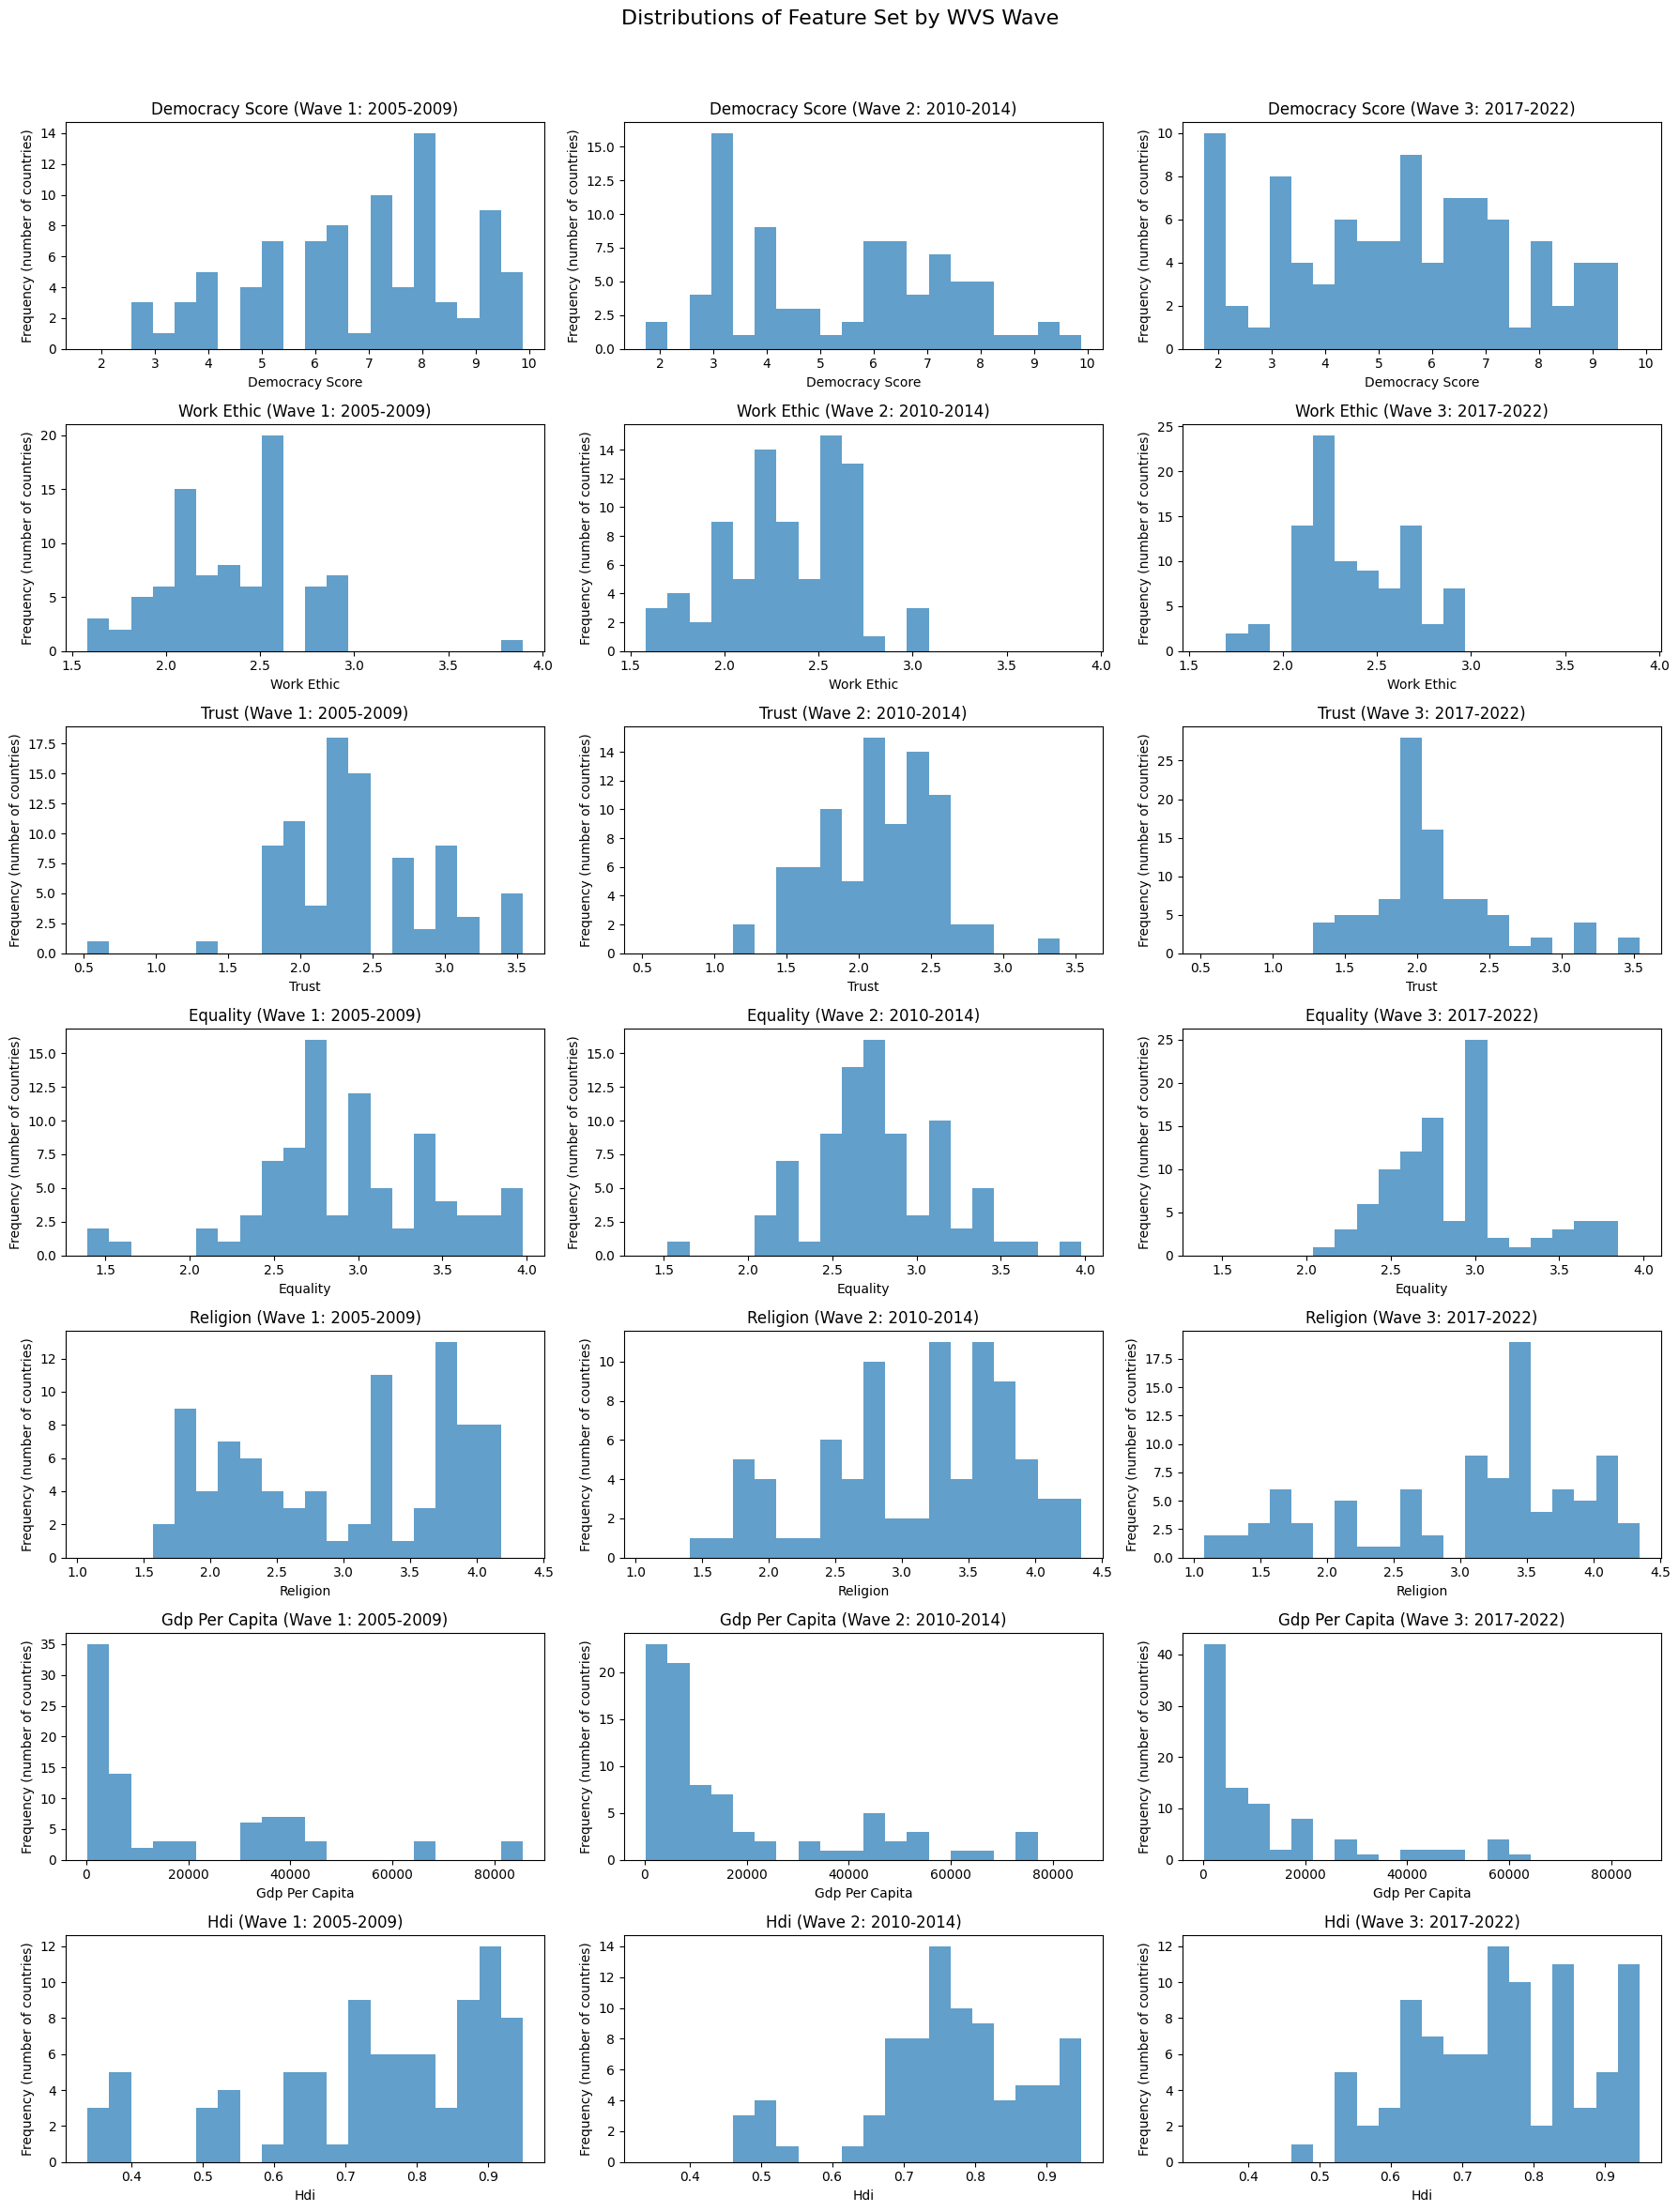

In [347]:
# create figure
fig, axes = plt.subplots(7, 3, figsize=(18, 24))
fig.suptitle('Distributions of Feature Set by WVS Wave', fontsize=16)

# I am add to waves so that they cover all of time from 1995.
# Assumption, associate data back one wave if is not in a wave. 
moral_values = ["democracy_score", "work_ethic", "trust", "equality", "religion", "gdp_per_capita", "hdi"]
waves = {1: [2005, 2009], 2: [2010, 2014], 3: [2017, 2022]}

# Create histograms for each combination
for i, value in enumerate(moral_values):
    # Get range for current moral value for consistent binning
    value_range = (df[value].min(), df[value].max())
    
    for j, (wave, years) in enumerate(waves.items()):
        # Filter data for current wave
        wave_data = df[(df['Year'] >= years[0]) & (df['Year'] <= years[1])]
        
        # Create histogram
        axes[i, j].hist(wave_data[value], bins=20, alpha=0.7, range=value_range)
        
        # Fix labeling
        value_name = value.replace('_', ' ').title()
        axes[i, j].set_title(f'{value_name} (Wave {wave}: {years[0]}-{years[1]})')
        axes[i, j].set_xlabel(value_name)
        axes[i, j].set_ylabel('Frequency (number of countries)')


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('figures/histograms.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

## 2c. Violin Plots and Scatter Plots 
### Violin Plots
The following violinplots show the distribution of each score --- trust, work ethic, equality, and religion --- when cut into income, human development index, and democracy index, quartiles. This plot yields several interesting conclusions:

1) Across all cuts, there appears to be a pretty general trend in mean score, either upward or downward. In other words, the mean score typically trends upward or downward over the quartiles we present. This suggests that the scores are quite correlated with income, human development, and democracy. We will see these correlations with democracy specifically in our scatterplots in the next section.

2) Most scores increase, on average, as income, HDI, and democracy increase. But work ethic and religion seem to _decrease_! This is very interesting and poses new questions about the relation between work ethic, religion, and democracy. It appears that wealthier countries and thus more democratic countries are less religious. This could make sense as we think of many religious states that are frequently undemocratic. The work ethic argument is harder to directly understand. Our prior was that a democratic country where there is a better institution of equality of opportunity would be correlated with more people valuing work ethic (the idea of pulling yourself up by your bootstraps). We will explore these relationships further in our baseline.

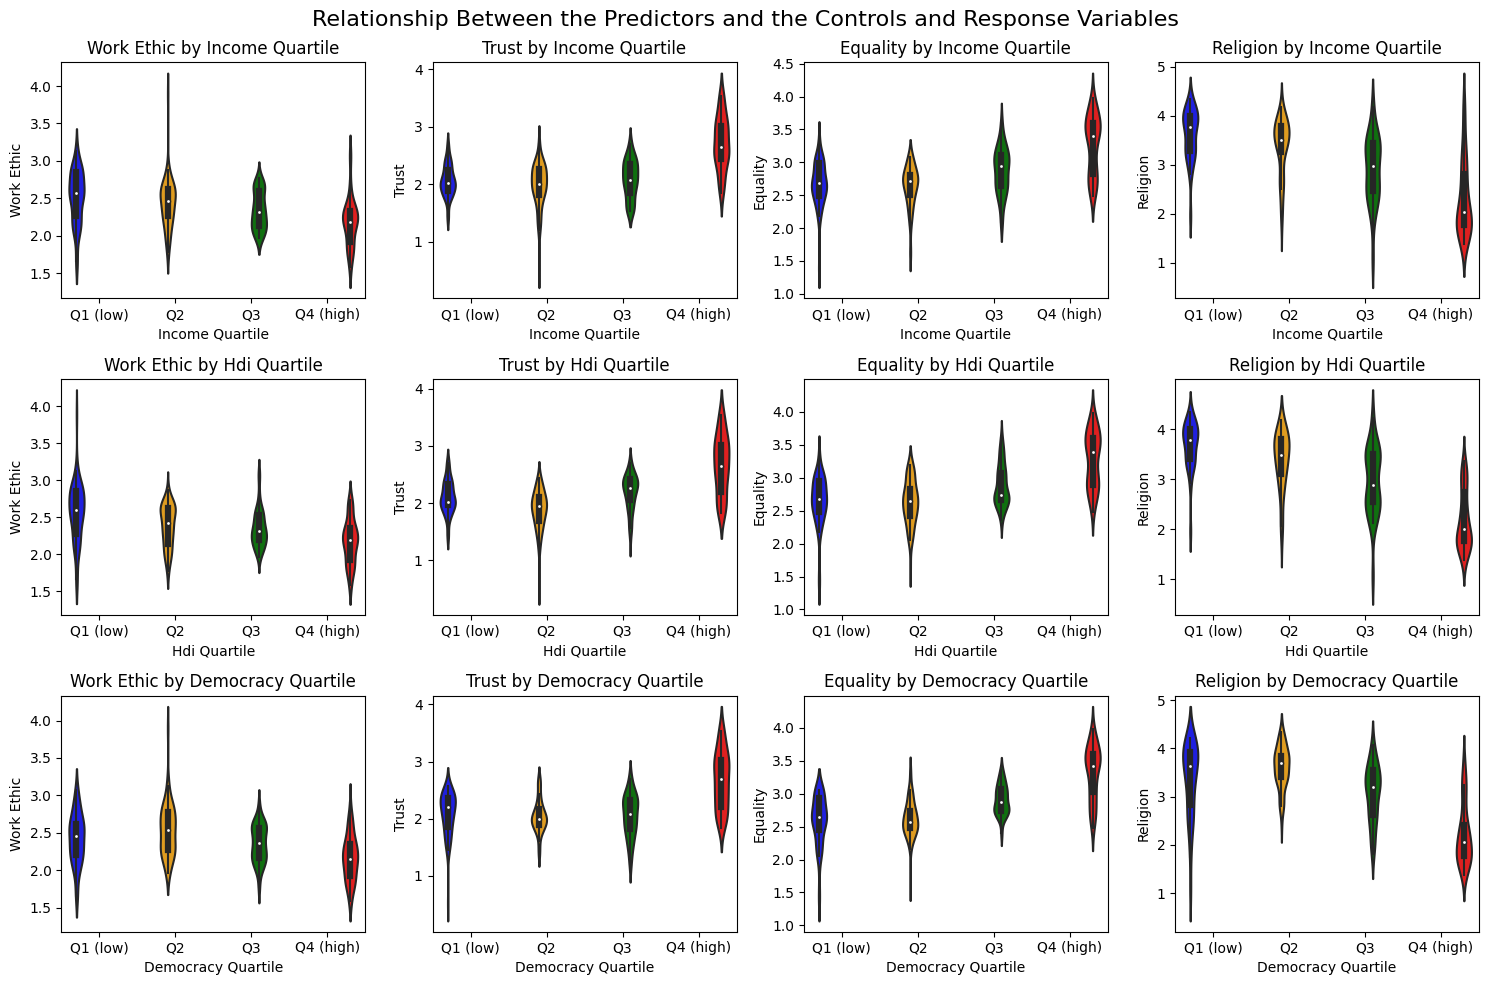

In [348]:
# create income quartiles
df['income_quartile'] = pd.qcut(df['gdp_per_capita'], q=4, labels=['Q1 (low)', 'Q2', 'Q3', 'Q4 (high)'])

# create HDI buckets
df['hdi_quartile'] = pd.qcut(df['hdi'], q=4, labels=['Q1 (low)', 'Q2', 'Q3', 'Q4 (high)'])

# create Democracy buckets
df['democracy_quartile'] = pd.qcut(df['democracy_score'], q=4, labels=['Q1 (low)', 'Q2', 'Q3', 'Q4 (high)'])

# create violinplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle('Relationship Between the Predictors and the Controls and Response Variables', fontsize=16)

cuts = ["income_quartile", "hdi_quartile", "democracy_quartile"]
scores = ["work_ethic", "trust", "equality", "religion"]

for i, cut in enumerate(cuts):
    for j, predictor in enumerate(scores):
        sns.violinplot(data=df, x=cut, y=predictor, ax=axes[i, j], hue = cut, palette = ["blue", "orange", "green", "red"])
        
        # fix labelling
        x_name = cut.replace('_', ' ').title() 
        y_name = predictor.replace('_', ' ').title()
        axes[i, j].set_title(f"{y_name} by {x_name}")
        axes[i, j].set_xlabel(f"{x_name}")
        axes[i, j].set_ylabel(f"{y_name}")

        axes[i, j].get_legend().remove()

plt.tight_layout()
plt.savefig('figures/violinplots.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

### Scatterplots
Below are the scatterplots of the predictor variables on the dependent variable.
1) From a first pass, the relationships between GDP and Democracy and HDI and Democracy do not appear linear, they look logarithmic. GDP and HDI also seem to have a strong positive relationship with democracy. This does not tell us that we are controlling for all important possible control variables, but does make the clear the importance of controlling for HDI and GDP. We will transform GDP to account for the nonlinearity before using it in our OLS model. 
2) Most relationships are generally positive, except religion and work ethic, which are negative.
3) We see that the religion and trust variables have the closest to a non-linear (logarithmic in this case) relationship with democracy index. We will run our OLS baseline model and examine the assumptions of the regression (linearity of residuals, homoskedaskcity) to determine whether linearity was a reasonable assumption or whether transformations should be done.

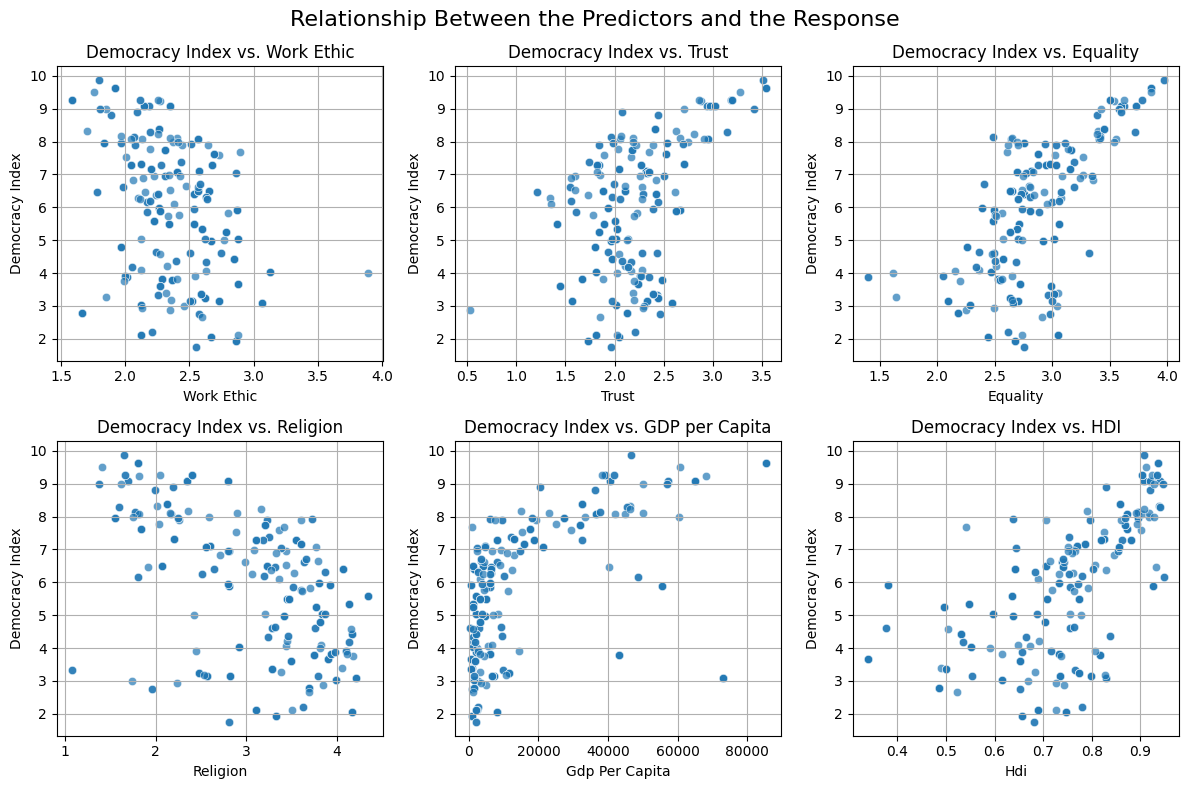

In [349]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Relationship Between the Predictors and the Response', fontsize=16)

ax = ax.ravel() 

x_vars = ['work_ethic', 'trust', 'equality', 'religion' , 'gdp_per_capita', 'hdi']
titles = ['Democracy Index vs. Work Ethic', 
          'Democracy Index vs. Trust', 
          'Democracy Index vs. Equality', 
          'Democracy Index vs. Religion', 
          'Democracy Index vs. GDP per Capita', 
          'Democracy Index vs. HDI']

for i, (x_var, title) in enumerate(zip(x_vars, titles)):
    sns.scatterplot(x=x_var, y='democracy_score', data=df, alpha=0.7, ax=ax[i])
    ax[i].set_title(title)
    ax[i].set_xlabel(x_var.replace('_', ' ').title()) 
    ax[i].set_ylabel('Democracy Index')
    ax[i].grid()

plt.tight_layout()
plt.savefig('figures/scatterplots.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

## 2d. Correlation Heatmap

Here is a heatmap showing the correlation amongst all the features. 
The highest correlations are among democracy, hdi, and gdp per capita. Religion has a negative correlation with every other predictor other than work ethic and the same for work ethic. All other variable have postive correlations with each other. The significant correlation between our predictors, our control variables, and our response variable suggest significant multicollinearity in our dataset.

1) Religion and work ethic are the only predictor that is negatively correlated with any other predictor (other than each other).

2) The most highly correlated variables are the democracy index, GDP per capita, and HDI. All three are also positively correlated with most of the moral value scores. This means that GDP per capita and HDI are two significant confounders — they are correlated both with our predictors of interest and with the outcome.

These correlations hint at the possible problem of multicolinearity. However, even if present, this is not a severe issue due to the magnitude of the coefficients of correlation we see above: for all the predictors we care about, |r| < 0.7.

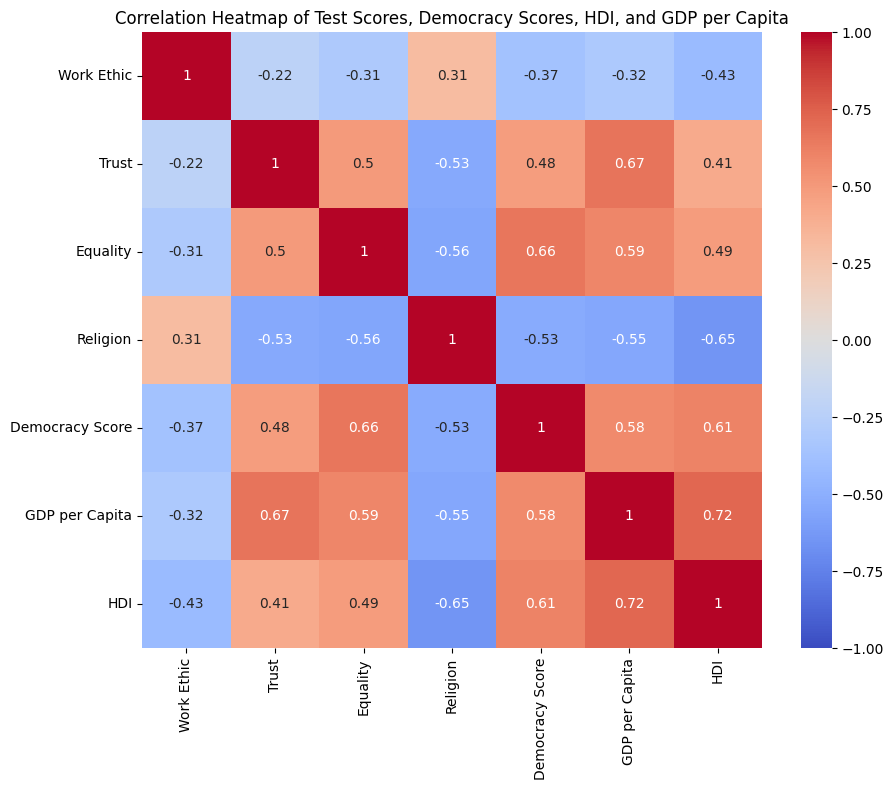

In [350]:
# Select the relevant columns for correlation
correlation_data = df[['work_ethic', 'trust', 'equality', 'religion', 'democracy_score', 'gdp_per_capita', 'hdi']]

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# change features to be better: work_ethic = Work Ethic, trust = Trust, religion = Religion, equality = Equality, hdi = HDI, gdp_per_capita = GDP per Capita, democracy_score = Democracy Score
correlation_matrix.columns = ['Work Ethic', 'Trust', 'Equality', 'Religion', 'Democracy Score', 'GDP per Capita', 'HDI']

correlation_matrix.index = ['Work Ethic', 'Trust', 'Equality', 'Religion', 'Democracy Score', 'GDP per Capita', 'HDI']

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Test Scores, Democracy Scores, HDI, and GDP per Capita')
plt.savefig('figures/corr_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## 2e. Discussion on confounders

Finally, we will discuss potential confounders in our dataset. First, we have already controlled for GDP per capita and HDI, which are clear confounding variables. Other unobserved confounding variables include other historical and institutional factors, like whether or not a country has had colonial history or what the educational system’s characteristics are, even beyond HDI. We can try to operationalize the fact that we have panel data and deploy country and wave fixed effects to control for these unobserved confounders to figure out the true effect of the moral values on democracy. However, since we have pretty limited time series data within countries, wave fixed effects will likely be all we are able to implement as adding country fixed effects will lead to significant overfitting.


# 3. Baseline Model and Results Interpretation

## 3a. Justification for Baseline Model

Based on our EDA, we believe that beginning with a multiple OLS regression and a LASSO regression as our baseline models is optimal. This is for a few reasons:

1. The relationships between our predictors and our response variable are reasonably linear (with the exception of GDP per capita which we will log transform). This means that a linear regression and its ensuing inference is likely to be valid. Of course, we saw some nonlinearities in our EDA, but these nonlinearities do not warrant a different model, in our opinions.

2. An OLS linear regression and a LASSO regression are both simple, interpretable ways of understanding the associations between our values and the democracy index and also provide separate, easily interpretable forms of feature selection. Starting our modeling with interpretable methods will be useful to us when we think about how we want to move forward with modeling!

3. The OLS linear regression gives us the chance to perform statistical inference which is useful as we are trying to understand what values are closely associated with democracy across different countries. 

4. The LASSO regression gives us another way to check on the features selected by our OLS regression while still preserving interpretability. 

In [351]:
# get our dataframe and create log gdp per capita plus equality squared (for later use)
df = pd.read_csv("cleaned_data/cleaned_wvs_data.csv")
df["log_gdp_per_capita"] = np.log(df["gdp_per_capita"])
df['equality_squared'] = df['equality']**2

In [352]:
df.head()

,Country,Year,democracy_score,work_ethic,trust,equality,religion,country,gdp_per_capita,gdp_per_capita_std,gender_beat_wife,gender_business_exec,gender_job_rights,gender_political_leaders,gender_rights,hdi,religion_against_science,religion_attendance,religion_child,religion_confidence,religion_god,religion_god_importance,religion_identification,religion_only_religion,religion_pray,religion_right,tolerance_chairty_confidence,tolerance_charitable_org,tolerance_human_rights,tolerance_immigrant_work,tolerance_immigrants,tolerance_other_race,trust_first_meet,trust_most_people,trust_neighborhood,trust_other_national,trust_other_religion,trust_personally,work_child,work_importance,work_membership_pro_org,work_success,wave,log_gdp_per_capita,equality_squared
0,Argentina,2017,6.96,2.308943,2.496937,3.349680,2.805873,ARG,14613.035649,-0.002063,4.713936,3.605759,3.879697,3.488592,4.287758,0.853,3.067606,2.024237,1.197550,2.760491,4.666443,3.575449,4.222373,1.703456,2.679850,2.161279,3.014905,0.318971,2.464931,1.415137,4.793826,4.862961,1.895876,1.016820,3.336227,2.635871,2.728511,3.368316,2.823198,4.181511,0.204718,2.026343,3.0,9.589669,11.220353
1,Argentina,2013,6.84,2.056866,2.421878,3.357302,2.710240,ARG,13080.254732,-0.076785,4.744030,3.402337,3.827324,3.145191,4.248363,0.846,3.072915,2.041670,1.161009,2.559173,4.669794,3.607358,4.166942,1.413569,2.592646,1.817325,2.797419,0.529656,2.441110,1.983986,4.860343,4.950563,1.765118,0.992374,3.154370,2.579455,2.605160,3.434793,2.032350,4.032228,0.334831,1.828054,2.0,9.478859,11.271477
2,Argentina,2017,6.96,2.308943,2.496937,3.349680,2.805873,ARG,14613.035649,-0.002063,4.713936,3.605759,3.879697,3.488592,4.287758,0.853,3.067606,2.024237,1.197550,2.760491,4.666443,3.575449,4.222373,1.703456,2.679850,2.161279,3.014905,0.318971,2.464931,1.415137,4.793826,4.862961,1.895876,1.016820,3.336227,2.635871,2.728511,3.368316,2.823198,4.181511,0.204718,2.026343,3.0,9.589669,11.220353
3,Armenia,2021,5.49,2.536477,1.888417,2.711727,3.447211,ARM,4972.783204,-0.472020,4.820998,2.601450,2.059424,2.311143,4.272454,0.774,3.561399,1.892354,1.671786,3.462924,4.733399,4.519103,4.525404,3.916994,3.426459,2.762293,2.510905,0.447444,1.990692,1.038217,4.176748,3.599520,1.424604,0.425027,2.997472,1.769796,1.383922,3.329680,3.556984,4.468816,0.435577,1.684531,3.0,8.511735,7.353462
4,Armenia,2021,5.49,2.536477,1.888417,2.711727,3.447211,ARM,4972.783204,-0.472020,4.820998,2.601450,2.059424,2.311143,4.272454,0.774,3.561399,1.892354,1.671786,3.462924,4.733399,4.519103,4.525404,3.916994,3.426459,2.762293,2.510905,0.447444,1.990692,1.038217,4.176748,3.599520,1.424604,0.425027,2.997472,1.769796,1.383922,3.329680,3.556984,4.468816,0.435577,1.684531,3.0,8.511735,7.353462


## 3b. Fitting of OLS and LASSO Models

Now, let's fit our models. 

1) We train two models --- one a standard OLS linear model, and the second a linear regression with LASSO (L1) regularization. The OLS model will include all regressors of interest, and will be used as a performance baseline and to conduct statistical inference. The LASSO model will select only the important features, as the L1 penalty pushes less important coefficients to zero. Note: for our project, it does not make sense to perform dimensionality reduction via PCA on all the numerical variables. This is because PCA loses the interpretability that we are interested in, because it would collapse work_ethic, trust, equality, and religion into its principal components, which of course prevents us from determining which of these aspects are the most important. Moreover, we only have a few components to begin with, so dimensionality reduction is practically trivial.

2) We deal with the fact that the GDP Per Capita variable is on a much larger scale than the four WVS indices in two different ways. For the LASSO model, we use StandardScalar to standardize all variables. This improves model performance and also ensures that regularization accurately selects features. This decision is based on our EDA from milestone 3. For the OLS model, though, performance is scale-invariant, which means that it will not improve the R^2 if we use a StandardScalar. Instead, the model will simply lose interpretability, because now regression coefficients aren't interpreted in absolute units, but rather in standard deviations, which is slightly more opaque. For the OLS model, we thus log transform GDP Per Capita, which puts it on a similar scale as the rest of the variables. The log transformation also makes its coefficient more intuitive to interpret, because we typically think of income in percent changes rather than in absolutes. This was also informed by our EDA where we saw the huge rightskew of GDP per capita.

3) Hyperparameter Tuning for LASSO model. Used 10-fold cross-validation with grid search. Tuned regularization strength (20 values log-spaced from 10^-2 to 10^2 which should very likely include our optimal regularization parameter). Cross-validation prevents overfitting, because it holds out validation data to prevent leakage. Grid search finds optimal complexity. Log-spaced regularization values test different strengths of L1 penalty. Under the best LASSO model, we can then see which features are most important (as these are the features with the highest coefficients/non-zero coefficients)


Note: We use a test train split (80-20 which is conventional) in order to ensure that any model we are using to draw feature importance conclusions from can generalize to unseen data. It would cast doubt on feature importance conclusions if the model we look at does not generalize well to unseen test data. 

We do not validate our initial baseline regression model to choose the parameters (non-LASSO) since we want to understand the general relationships of all of our variables from the get-go and are thus not testing different OLS models. We still get a cross validation score for future comparison and model selection. Cross-validation with LASSO parameters fulfills the role of testing different combinations of variables and selecting which features together best minimize MSE and thus is where we would be doing our model selection. At the end of these analyses, we will compare test MSEs to evaluate our model to ensure that our conclusions remain reasonable.

In [353]:
# split df into X and y

y = df['democracy_score']
X = df.drop(columns=['democracy_score'])

# split X and y into training and testing sets
X_train_f, X_test_f, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)


predictors = ["work_ethic", "trust", "equality", "religion", "log_gdp_per_capita", "hdi"]
X_train = X_train_f[predictors]
X_test = X_test_f[predictors]

In [354]:
"""
Train OLS model
"""
# set up ols pipeline
ols_pipeline = Pipeline(steps=[
   ('regressor', LinearRegression())
])

# train OLS model and get cv results for our own understanding
ols_cv = cross_validate(
    ols_pipeline,
    X_train, y_train,
    cv=10,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

# get mean validation mse and std of mses
mean_mse = -ols_cv['test_score'].mean()
std_mse = ols_cv['test_score'].std()

print(f"OLS Cross-validation MSE: {mean_mse:.3f} (+/- {std_mse:.3f})")


ols_pipeline.fit(X_train, y_train)
y_pred_ols = ols_pipeline.predict(X_train)
train_mse = mean_squared_error(y_train, y_pred_ols)
print(f"OLS Train MSE: {train_mse:.3f}")


ols_r2 = ols_pipeline.score(X_train, y_train)

print(f"OLS R-squared: {ols_r2:.3f}")

OLS Cross-validation MSE: 2.146 (+/- 0.937)
OLS Train MSE: 1.983
OLS R-squared: 0.560


In [355]:
"""
Train LASSO Model
"""

seed = 109

# set up lasso pipeline
lasso_pipeline = Pipeline(steps=[
   ('scaler', StandardScaler()),
   ('regressor', Lasso(random_state = seed, max_iter=10000))
])

# define lasso parameter grid
lasso_param_grid = {
    'regressor__alpha': np.logspace(-2, 2, 20)
}

# set up grid search
lasso_cv = GridSearchCV(
    lasso_pipeline,
    lasso_param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

lasso_cv.fit(X_train, y_train)

print("LASSO Best Parameters:", lasso_cv.best_params_)
print("LASSO Best CV Mean Squared Error:", -lasso_cv.best_score_)

lasso_train_mse = -lasso_cv.score(X_train, y_train)
print(f"LASSO Train MSE: {lasso_train_mse:.3f}")

# get lasso r-squared
lasso_r2 = r2_score(y_train, lasso_cv.predict(X_train))

print(f"LASSO Train R-squared: {lasso_r2:.3f}")

LASSO Best Parameters: {'regressor__alpha': 0.04281332398719394}
LASSO Best CV Mean Squared Error: 2.110141160603594
LASSO Train MSE: 1.989
LASSO Train R-squared: 0.559


We see that the LASSO performs slightly better in terms of CV MSE compared to the OLS model telling us that the feature selection performed by the LASSO was valuable and potentially prevented some overfitting/lack of generalization. Both mean CV MSEs do show that these models generally do not appear to significantly overfit as the error is fairly low (much lower than just predicting the mean as well). 

Here is a graph illustrating our MSEs for our regularization terms which shows why we chose the alpha value that we did.

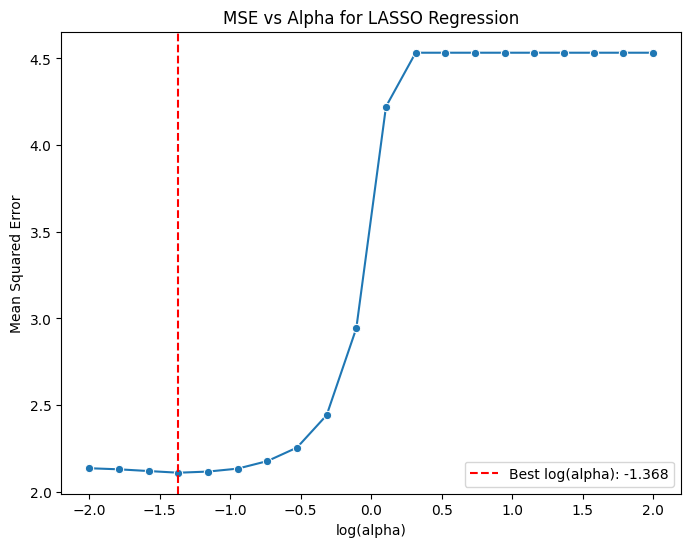

In [356]:
# get alphas and MSE scores from LASSO grid search results
alphas = lasso_cv.cv_results_['param_regressor__alpha'].data.astype(float)
mse_scores = -lasso_cv.cv_results_['mean_test_score']  # negative because we used neg_mean_squared_error
best_alpha = lasso_cv.best_params_['regressor__alpha']

# create plot
plt.figure(figsize=(8, 6))
sns.lineplot(x=np.log10(alphas), y=mse_scores, marker = 'o', errorbar=None)
plt.axvline(x=np.log10(best_alpha), color='r', linestyle='--', label=f'Best log(alpha): {np.log10(best_alpha):.3f}')
plt.xlabel('log(alpha)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha for LASSO Regression')
plt.legend()
plt.show()

## 3c. Interpretation of Baseline Model Coefficients and Results

Now, let's begin the analysis and model evaluation. First, here are the coeffficient values for both models.

In [357]:
# get best models / pipelines
best_model_ols = ols_pipeline.named_steps['regressor']
best_pipeline_ols = ols_pipeline
best_model_lasso = lasso_cv.best_estimator_.named_steps['regressor']
best_pipeline_lasso = lasso_cv.best_estimator_

# get coefficients from best models
ols_intercept = best_model_ols.intercept_
ols_coef = best_model_ols.coef_
ols_coef_full = np.concatenate(([ols_intercept], ols_coef))

lasso_intercept = best_model_lasso.intercept_
lasso_coef = best_model_lasso.coef_
lasso_coef_full = np.concatenate(([lasso_intercept], lasso_coef))

# create results dataframes
ols_results = pd.DataFrame({
    'Feature': ['Intercept'] + list(predictors),
    'Coefficient': ols_coef_full
})

lasso_results = pd.DataFrame({
    'Feature': ['Intercept'] + list(predictors),
    'Coefficient': lasso_coef_full
})

# rename features
feature_map = {
    'Intercept': "Intercept",
    'work_ethic': 'Work Ethic',
    'trust': 'Trust',
    'equality': 'Equality',
    'religion': 'Religion',
    'log_gdp_per_capita': 'Log GDP Per Capita',
    'hdi': 'Human Development Index',
}

ols_results['Feature'] = ols_results['Feature'].map(feature_map)
lasso_results['Feature'] = lasso_results['Feature'].map(feature_map)

ols_results_sorted = ols_results.sort_values(by='Coefficient', key=abs, ascending=False)
lasso_results_sorted = lasso_results.sort_values(by='Coefficient', key=abs, ascending=False)

print("OLS Coefficients")
display(ols_results_sorted)

print("LASSO Coefficients")
display(lasso_results_sorted)

OLS Coefficients


,Feature,Coefficient
0,Intercept,-4.816867
6,Human Development Index,2.322734
3,Equality,1.990174
2,Trust,0.499713
1,Work Ethic,-0.458274
5,Log GDP Per Capita,0.324479
4,Religion,0.098113


LASSO Coefficients


,Feature,Coefficient
0,Intercept,5.764671
3,Equality,0.864603
5,Log GDP Per Capita,0.479427
6,Human Development Index,0.241334
2,Trust,0.190430
1,Work Ethic,-0.128470
4,Religion,-0.000000


For more clarity and interpretability, we graph our coefficients to show their magnitudes:

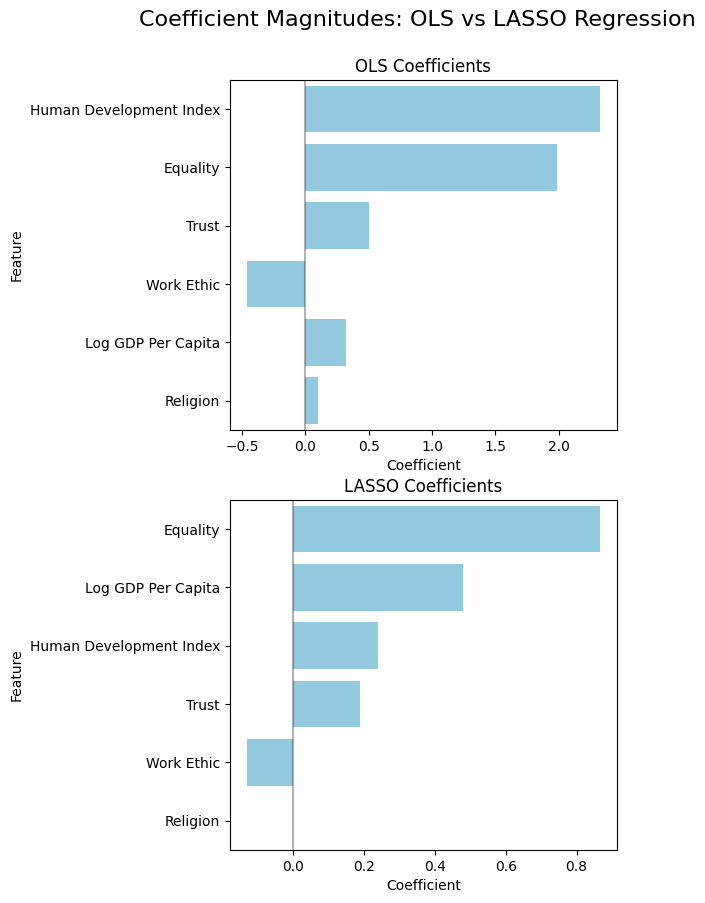

In [358]:
fig, axes = plt.subplots(2, 1, figsize=(5, 10))
fig.suptitle('Coefficient Magnitudes: OLS vs LASSO Regression', fontsize=16, y=0.95)

axes = axes.flatten()

# create OLS plot
sns.barplot(data=ols_results_sorted[1:], y='Feature', x='Coefficient', ax=axes[0], orient='h', color='skyblue')
axes[0].set_title(f'OLS Coefficients')
axes[0].axvline(0, color='black', alpha=0.3)

sns.barplot(data=lasso_results_sorted[1:11], y='Feature', x='Coefficient', ax=axes[1], orient='h', color='skyblue')
axes[1].set_title(f'LASSO Coefficients')
axes[1].axvline(0, color='black', alpha=0.3)

From comparing the OLS and LASSO coefficients, we can see some interesting patterns. In the OLS model, the Human Development Index and equality show strong positive relationships with democracy scores, followed by smaller positive effects from trust and log GDP per capita, while work ethic shows a negative relationship. eligion appears to have a near zero relationship with democracy. Since our moral values are on the same scale, we can thus see that equality appears to have the strongest relationship with the democracy index.

When we look at the LASSO results, which reduce less important features and uses the standardized versions of our predictors, equality emerges as clearly the strongest predictor, followed by log GDP per capita, while HDI's importance is notably reduced. This can start to suggest that equality and economic development (measured by GDP per capita) are the strongest/most fundamental associates of democracy. Obviously, there is more work to be done to make this full conclusion, but off of our first pass, these results appear to support the above conclusions.

### Analytic and Bootstrap Confidence Intervals

Now, let's calculate the standard errors for the OLS model. This will help us understand whether we believe our coefficients are significantly different from zero given our normality assumption on the data. We do not calculate standard errors for the LASSO model since there is no consensus on a statistically valid way to calculate standard errors for LASSO in the literature. Any statistically valid method here requires stringent assumptions and a very large dataset (Zhao et. al, 2021). This is because of the lack of an analytical solution for standard errors due to our regularization term. Regardless, the feature selection that was done by our LASSO model is useful in helping us understand the most important predictors of a democratic nation. Now, we will compute both the analytic confidence intervals for the OLS model and the bootstrapped confidence intervals. We use both for the following reasons:

The analytic confidence intervals are typically used in statistical analyses and are based in statistical theory. However, they require the assumptions of normality of residuals (errors) and homoskedasticity of residuals apply. In the case that these assumptions are not met, the bootstrap confidence interval provides us a more robust interval of estimates and can also capture non-linearities and asymmetries in the sampling distribution of estimates.

Citation: Sen Zhao. Daniela Witten. Ali Shojaie. "In Defense of the Indefensible: A Very Naïve Approach to High-Dimensional Inference." Statist. Sci. 36 (4) 562 - 577, November 2021. https://doi.org/10.1214/20-STS815

In [359]:
"""
Get analytic confidence intervals
"""

y_train_preds = best_pipeline_ols.predict(X_train)

n, p = X_train.shape
residuals = y_train - y_train_preds

# estimate variance of the error term
s2 = np.sum(residuals ** 2) / (n - p - 1)

# calculate standard errors
X_design_ols = np.hstack([np.ones((n, 1)), X_train])  # add intercept
se = np.sqrt(s2 * np.diag(np.linalg.inv(X_design_ols.T @ X_design_ols)))

# calculate confidence intervals
z_crit = 1.96
ci_lower_analytic = ols_coef_full - z_crit * se
ci_upper_analytic = ols_coef_full + z_crit * se

# add to OLS results dataframe
ols_results['SE'] = se
ols_results['CI_Lower_Analytic'] = ci_lower_analytic
ols_results['CI_Upper_Analytic'] = ci_upper_analytic


In [360]:
def bootstrap(X, y, pipeline, n_bootstraps=1000):
    """
    Performs bootstrap resampling and returns coefficient estimates for each bootstrap sample.
    - returns an array of shape (n_bootstraps, n_features + 1) containing coefficient estimates for each bootstrap sample, including intercept
    """
    bootstrap_coefs = []
    
    for i in range(n_bootstraps):
        # generate bootstrap sample
        X_bootstrap, y_bootstrap = resample(X, y, random_state=i)
        
        # fit pipeline on bootstrap sample
        pipeline_boot = clone(pipeline)
        pipeline_boot.fit(X_bootstrap, y_bootstrap)
                
        # get coefficients. includes intercept.
        coef_boot = np.concatenate([[pipeline_boot.named_steps['regressor'].intercept_], pipeline_boot.named_steps['regressor'].coef_])
        
        bootstrap_coefs.append(coef_boot)
    
    return np.array(bootstrap_coefs)

In [361]:
"""
Get bootstrap confidence intervals
"""
# get bootstrapped coefficients
ols_coef_bootstrap = bootstrap(X_train, y_train, best_pipeline_ols)
bootstrap_distributions = [ols_coef_bootstrap[:, i] for i in range(ols_coef_bootstrap.shape[1])]

# calculate standard errors
se_boot = np.std(ols_coef_bootstrap, axis=0)

# calculate bootstrapped confidence intervals
ci_lower_boot = ols_coef_full - z_crit * se_boot
ci_upper_boot = ols_coef_full + z_crit * se_boot

# add to OLS results dataframe
ols_results['SE_Boot'] = se_boot
ols_results['CI_Lower_Boot'] = ci_lower_boot
ols_results['CI_Upper_Boot'] = ci_upper_boot
ols_results['Bootstrap'] = bootstrap_distributions

display(ols_results)

,Feature,Coefficient,SE,CI_Lower_Analytic,CI_Upper_Analytic,SE_Boot,CI_Lower_Boot,CI_Upper_Boot,Bootstrap
0,Intercept,-4.816867,1.767536,-8.281237,-1.352497,2.462306,-9.642987,0.009253,"[-6.86206327661554, -4.180909475446801, -7.609..."
1,Work Ethic,-0.458274,0.316687,-1.078980,0.162432,0.354627,-1.153343,0.236795,"[-0.26835833793454883, -0.21713896007607122, 0..."
2,Trust,0.499713,0.268839,-0.027210,1.026637,0.228947,0.050977,0.948449,"[0.3463660669809283, 0.6987807684338071, 0.661..."
3,Equality,1.990174,0.280718,1.439967,2.540381,0.246923,1.506204,2.474144,"[2.125356694361907, 2.067934345651348, 1.95124..."
4,Religion,0.098113,0.178654,-0.252048,0.448275,0.238755,-0.369847,0.566073,"[0.364735358112629, -0.03675705933955104, 0.33..."
5,Log GDP Per Capita,0.324479,0.190183,-0.048280,0.697238,0.259312,-0.183773,0.832731,"[0.23988205685591732, 0.4454620894149023, 0.21..."
6,Human Development Index,2.322734,1.959700,-1.518279,6.163747,2.205418,-1.999884,6.645353,"[4.259604588833062, -0.9416294373780563, 4.676..."


Here are visualizations of the distributions for the bootstrapped LASSO coefficients with the bootstrapped and analytic confidence intervals overlayed on top of them.

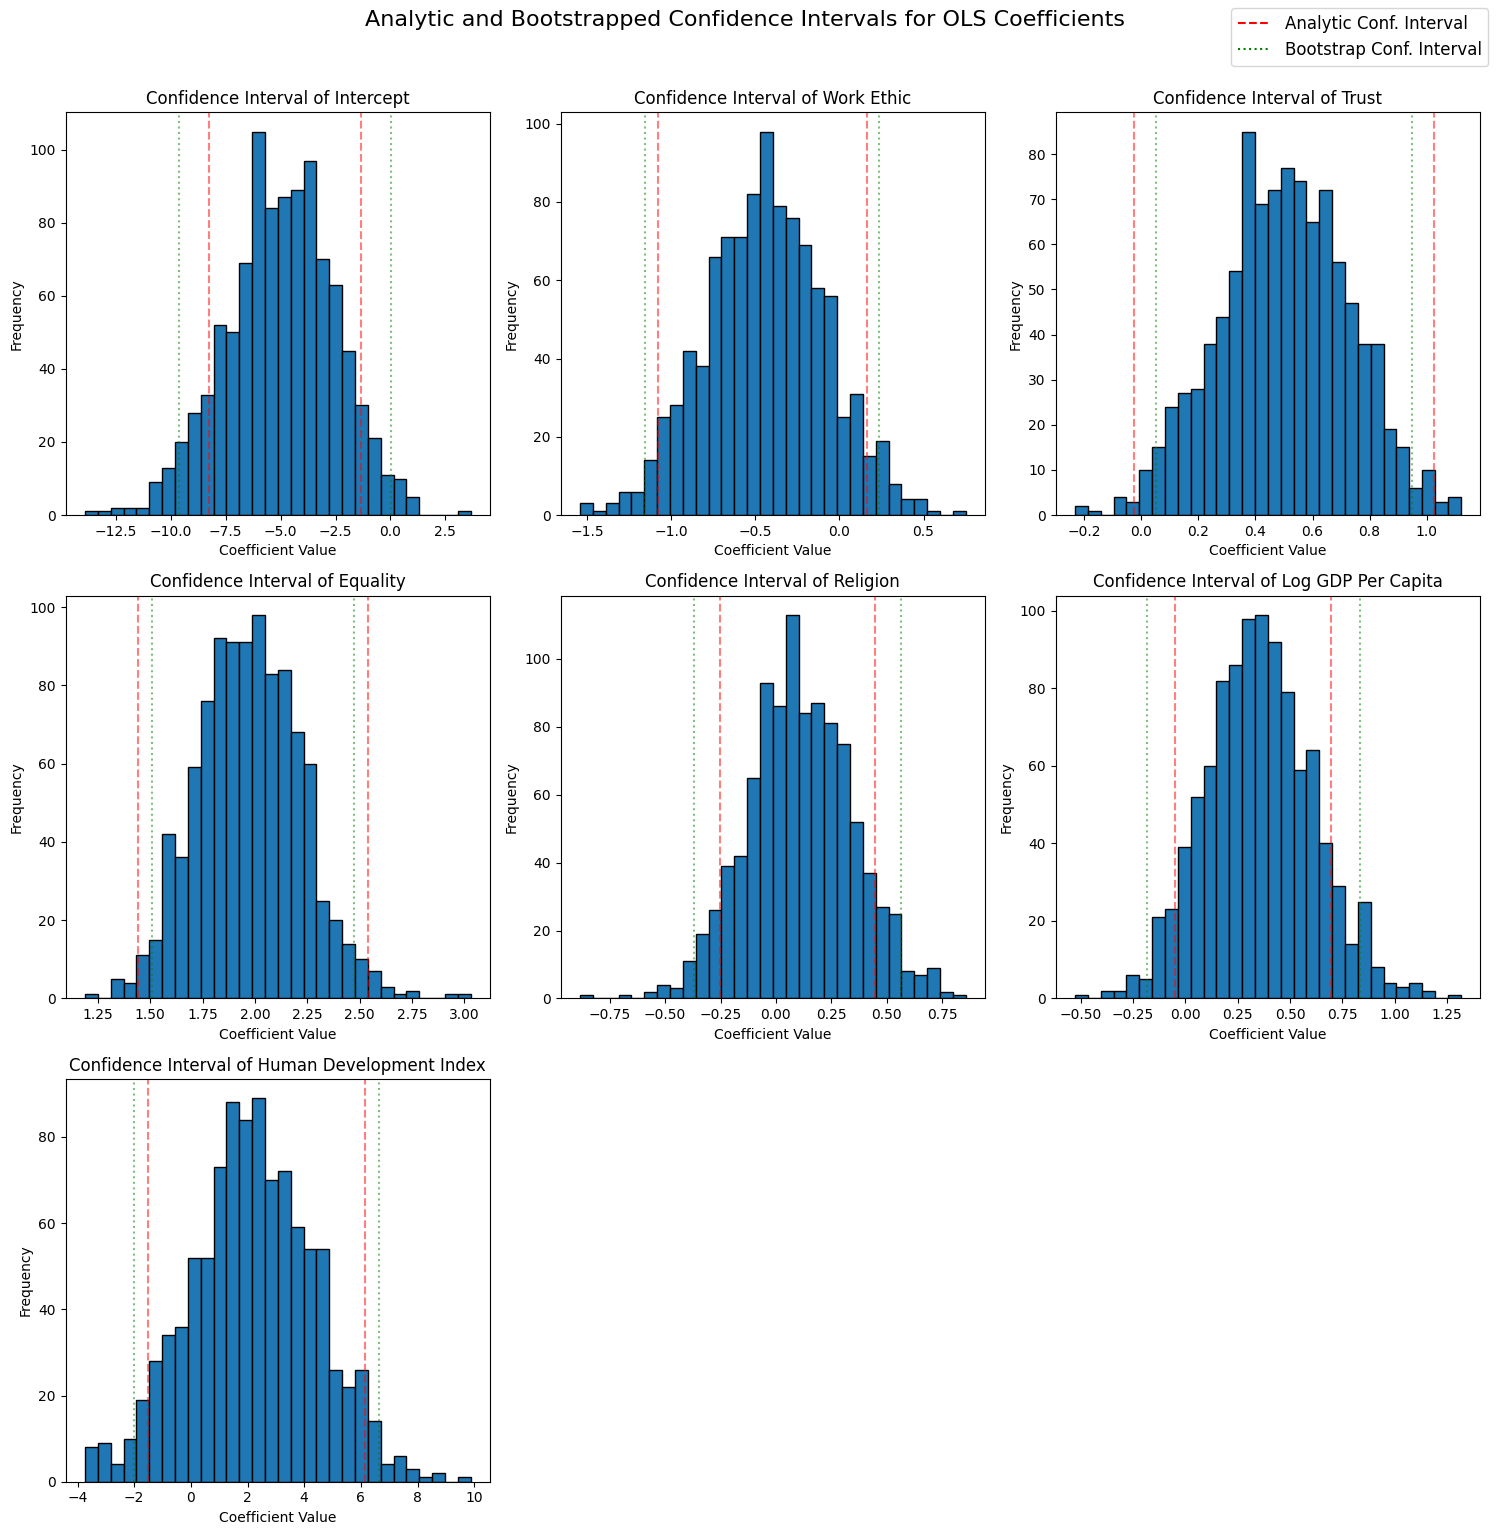

In [362]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Analytic and Bootstrapped Confidence Intervals for OLS Coefficients', fontsize=16, y=1.02)
axes = axes.flatten()

# create legend
legend_elements = [
    plt.Line2D([0], [0], color='r', linestyle='--', label='Analytic Conf. Interval'),
    plt.Line2D([0], [0], color='g', linestyle=':', label='Bootstrap Conf. Interval')
]

# plot histograms for each feature
for i, (idx, row) in enumerate(ols_results.iterrows()):
    feature = row['Feature']
    ci_lower_analytic = row['CI_Lower_Analytic']
    ci_upper_analytic = row['CI_Upper_Analytic']
    ci_lower_boot = row['CI_Lower_Boot']
    ci_upper_boot = row['CI_Upper_Boot']
    coef_dist = row["Bootstrap"]  
      
    # Create histogram
    axes[i].hist(coef_dist, bins=30, edgecolor='black')
    
    # Add vertical lines for confidence intervals
    axes[i].axvline(x=ci_lower_analytic, color='r', linestyle='--', alpha=0.5)
    axes[i].axvline(x=ci_upper_analytic, color='r', linestyle='--', alpha=0.5)
    axes[i].axvline(x=ci_lower_boot, color='g', linestyle=':', alpha=0.5)
    axes[i].axvline(x=ci_upper_boot, color='g', linestyle=':', alpha=0.5)
    
    # Add title and labels
    axes[i].set_title(f'Confidence Interval of {feature}')
    axes[i].set_xlabel('Coefficient Value')
    axes[i].set_ylabel('Frequency')

# Hide empty subplots
for i in range(len(lasso_results), len(axes)):
    axes[i].set_visible(False)

fig.legend(handles=legend_elements, loc='upper right', fontsize = 12)

plt.tight_layout()
plt.show()

Using the OLS model, we can now do proper inference to see which of the features are statistically significant. Based on both the bootstrapped and analytic confidence intervals, the "equality" metric is the only significant predictor of democracy, though log GDP per capita and Trust are both nearly significant. This is consistent with the analysis from the LASSO regression above, which selected equality as the strongest predictor. Intuitively, it makes sense that few metrics would be significant. That is because many of these indices are correlated, and so by including them all in a single regression, it dilutes the effect of each one by eliminating confounders and minimizing omitted variable bias. Also, it makes sense that equality is the strongest predictor of democracy: democracies are built upon equality!

### Aside on Testing Quadratic Relationship for Equality

Now, we will use statistical inference to check whether equality actually exhibits a quadratic relationship with democracy score. To do this, we will include an equality squared term in the OLS regression, and see whether it's statistically significant at the five percent level.

The idea is that we want to pin down the precise relationship between equality and democracy. We have already established that as equality increases, democracy increases too, but we want to figure out whether that relationship is linear or not. I.e. does the effect get stronger or weaker at different values of the independent variable. To do this, we see whether the quadratic term is signficiant. A non-significant squared term suggests that the relationship is linear.

In [363]:
X_train_v2 = X_train.copy()

# add equality squared to predictors
X_train_v2['equality_squared'] = X_train_v2['equality']**2

# get predictors list
predictors_v2 = list(X_train_v2.columns)



ols_pipeline_eq = Pipeline([
    ('regressor', LinearRegression())
])
ols_cv_eq = cross_validate(
    ols_pipeline_eq,
    X_train_v2, y_train,
    cv=10,
    scoring='neg_mean_squared_error',
    return_train_score=True
)
ols_pipeline_eq.fit(X_train_v2, y_train)
coef_dict = dict(zip(predictors_v2, ols_pipeline.named_steps['regressor'].coef_))
for pred, coef in coef_dict.items():
    print(f"{pred}: {coef:.3f}")
X_with_const = sm.add_constant(X_train_v2)
model_eq_squared = sm.OLS(y_train, X_with_const)
results_eq_squared = model_eq_squared.fit()
print("\nEquality squared p-value:", results_eq_squared.pvalues['equality_squared'])

work_ethic: -0.458
trust: 0.500
equality: 1.990
religion: 0.098
log_gdp_per_capita: 0.324
hdi: 2.323

Equality squared p-value: 0.115974730666266


Note that the equality_squared coefficient is not stastistically significant. This means that there is no statistically significant non-linear relationship between any of the variables and democracy score.

## 3d. Wave Fixed Effects Baseline Model and Results Analysis

Next, we will see if equality is still significant when we include wave fixed effects. This idea comes directly from our discussion of fixed effects in milestone 3 and our above EDA. As discussed above, even though adding country fixed effects would be ideal (so we can also control for time-invariant country specific characteristics), our dataset does not have enough time-series data for countries to implement these fixed effects without overfitting (we had a 0.99 R-squared value when we tested the use of country fixed effects).

In [364]:

# get dummies for our waves to use for fixed effects and plug that into our X matrix
wave_dummies = pd.get_dummies(X_train_f['wave'], prefix='wave', drop_first=True, dtype=int)
X_train_full = pd.concat([
    X_train,
    wave_dummies
], axis=1)

# set up OLS FE pipeline and get cross-validation 
ols_fe_pipeline = Pipeline(steps=[
   ('regressor', LinearRegression())
])
ols_fe_cv = cross_validate(
    ols_fe_pipeline,
    X_train_full, y_train,
    cv=10,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

# get mean validation mse and std dev of mses
ols_fe_pipeline.fit(X_train_full, y_train)

best_model_fe = ols_fe_pipeline.named_steps['regressor']

# get our coefficients and turn into a dataframe for interpretations
best_pipeline_fe = ols_fe_pipeline
fe_coef_full = np.concatenate(([best_model_fe.intercept_], best_model_fe.coef_))
fe_results = pd.DataFrame({
    'Feature': ['Intercept'] + list(X_train_full.columns), 
    'Coefficient': fe_coef_full
})

# get bootstrapped coefficients
fe_coef_bootstrap = bootstrap(X_train_full, y_train, best_pipeline_fe)
bootstrap_distributions_fe = [fe_coef_bootstrap[:, i] for i in range(fe_coef_bootstrap.shape[1])]

# calculate standard errors
se_boot_fe = np.std(fe_coef_bootstrap, axis=0)

# calculate bootstrapped confidence intervals
ci_lower_boot_fe = fe_coef_full - z_crit * se_boot_fe
ci_upper_boot_fe = fe_coef_full + z_crit * se_boot_fe

# get residuals in order to get confidence intervals 
y_pred_fe = best_pipeline_fe.predict(X_train_full)
n_fe, p_fe = X_train_full.shape
residuals_fe = y_train - y_pred_fe

# calculate confidence intervals for our fixed effects model
s2_fe = np.sum(residuals_fe ** 2) / (n_fe - p_fe - 1)
X_design_fe = np.hstack([np.ones((n_fe, 1)), X_train_full])
se_fe = np.sqrt(s2_fe * np.diag(np.linalg.inv(X_design_fe.T @ X_design_fe)))
z_crit = 1.96 
ci_lower_fe = fe_coef_full - z_crit * se_fe
ci_upper_fe = fe_coef_full + z_crit * se_fe
fe_results['SE'] = se_fe
fe_results['CI_Lower'] = ci_lower_fe  
fe_results['CI_Upper'] = ci_upper_fe 

# add to OLS results dataframe
fe_results['SE_Boot'] = se_boot_fe
fe_results['CI_Lower_Boot'] = ci_lower_boot_fe
fe_results['CI_Upper_Boot'] = ci_upper_boot_fe

display(fe_results)

,Feature,Coefficient,SE,CI_Lower,CI_Upper,SE_Boot,CI_Lower_Boot,CI_Upper_Boot
0,Intercept,-2.211857,1.777574,-5.695901,1.272187,2.558410,-7.226341,2.802626
1,work_ethic,-0.599025,0.304039,-1.194940,-0.003109,0.352024,-1.288992,0.090943
2,trust,0.056251,0.272586,-0.478017,0.590520,0.259882,-0.453117,0.565619
3,equality,1.816566,0.274802,1.277954,2.355178,0.225945,1.373713,2.259418
4,religion,-0.052947,0.173505,-0.393017,0.287124,0.243537,-0.530279,0.424385
5,log_gdp_per_capita,0.368399,0.186915,0.002045,0.734753,0.263276,-0.147622,0.884420
6,hdi,2.235681,1.914687,-1.517106,5.988468,2.126553,-1.932363,6.403725
7,wave_2.0,-1.077740,0.255992,-1.579484,-0.575997,0.251781,-1.571231,-0.584250
8,wave_3.0,-0.962041,0.235939,-1.424481,-0.499601,0.222247,-1.397645,-0.526437


In [365]:
cv_mse_fe = -ols_fe_cv['test_score'].mean()
cv_std_fe = ols_fe_cv['test_score'].std()

print(f"Fixed Effects Cross-validation MSE: {cv_mse_fe:.3f} (+/- {cv_std_fe:.3f})")

# get mse of our fixed effects model
mse_fe = mean_squared_error(y_train, y_pred_fe)

print(f"Training MSE of Fixed Effects model: {mse_fe:.3f}")

# get r-squared value of our fixed effects model
r2_fe = r2_score(y_train, y_pred_fe)

print(f"R-squared value of Fixed Effects model: {r2_fe:.3f}")

Fixed Effects Cross-validation MSE: 1.976 (+/- 0.778)
Training MSE of Fixed Effects model: 1.783
R-squared value of Fixed Effects model: 0.604


In [366]:
# get test mse and r-squared for our fixed effects model
X_test_full = pd.concat([
    X_test,
    pd.get_dummies(X_test_f['wave'], prefix='wave', drop_first=True, dtype=int)
], axis=1)

y_pred_fe_test = best_pipeline_fe.predict(X_test_full)

mse_fe_test = mean_squared_error(y_test, y_pred_fe_test)

print(f"Test MSE of Fixed Effects model: {mse_fe_test:.3f}")

r2_fe_test = r2_score(y_test, y_pred_fe_test)

print(f"Test R-squared of Fixed Effects model: {r2_fe_test:.3f}")

Test MSE of Fixed Effects model: 1.246
Test R-squared of Fixed Effects model: 0.684


Interestingly, not only does equality remain significant, but the wave dummies are significant as well based on both types of CIs! In addition, work ethic becomes close to significant while trust no longer is close to significant. Log GDP per capita is also close to significant (bootstrap CIs are not significant). When we include wave fixed effects, we're essentially looking at how changes in these variables relate to changes in democracy scores by country, while controlling for any global trends that affect all countries in a given wave since we include wave dummies in our regression. This is different from our previous analysis that looked at differences between countries without controlling for the time period. Given that the same variables appear significant (and trust is less significant), it appears that these time effects are not large confounders of the associations in our data outside of its effect on trust and work ethic. This model, does, however, perform better than both LASSO and OLS in terms of mean CV MSE. As such, it could be valuable to include these dummies for use in our final model to continue controlling for these potential time-based confounders.

Also, it is worth mentioning that both of our wave dummies are significant at the 5% level and have negative coefficients. This actually indicates that being in wave 2 or wave 3 (compared to being in wave 1 and holding all other values constant) is associated with a lower democracy score. This could suggest that countries are actually just in general becoming less democratic over time in a way unrelated to their values!

## 3e. OLS Assumptions Check and Discussion of Final Model

We will now check whether our OLS regression assuptions are satisfied (which will help us make a decision on whether we think our analytical CIs are valid). First, we will see whether the residuals are approximately normally distributed. We will do this analysis for both our original regression and our fixed effects regression.

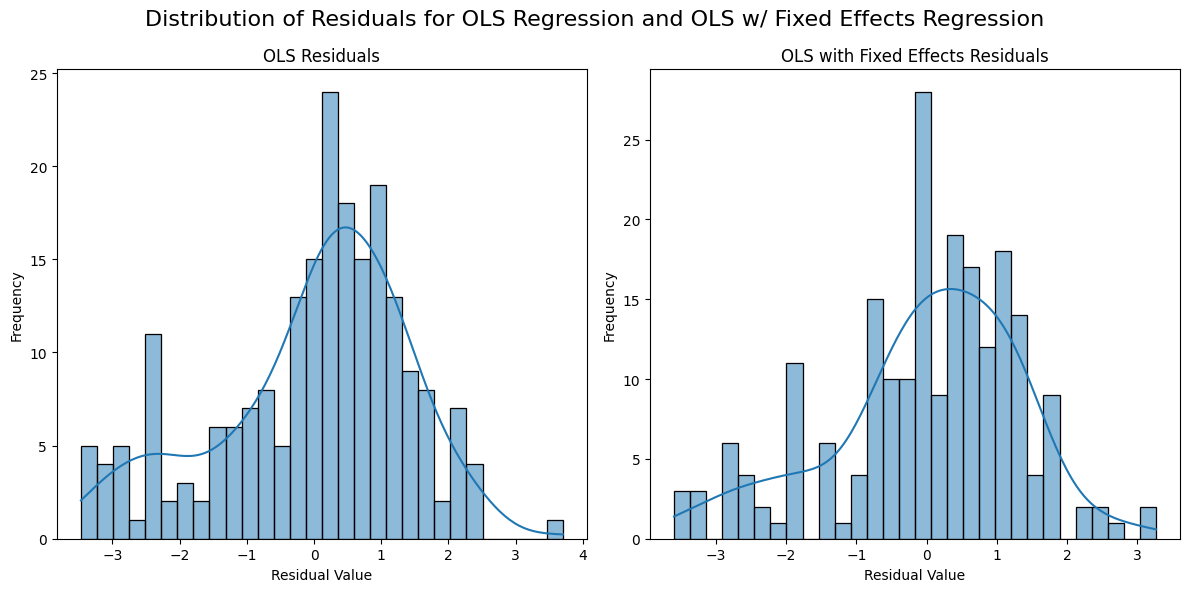

In [367]:
# create 1 x 2 grid for our histogram of residuals: one for OLS and one for fixed effects

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('Distribution of Residuals for OLS Regression and OLS w/ Fixed Effects Regression', fontsize=16)


sns.histplot(residuals, bins=30, ax=axes[0], kde=True)
axes[0].set_title('OLS Residuals')
axes[0].set_xlabel('Residual Value')
axes[0].set_ylabel('Frequency')

sns.histplot(residuals_fe, bins=30, ax=axes[1], kde=True)
axes[1].set_title('OLS with Fixed Effects Residuals')
axes[1].set_xlabel('Residual Value')
axes[1].set_ylabel('Frequency')

plt.tight_layout()

Next, we will check to see whether the residuals are homoskedastic and linear.

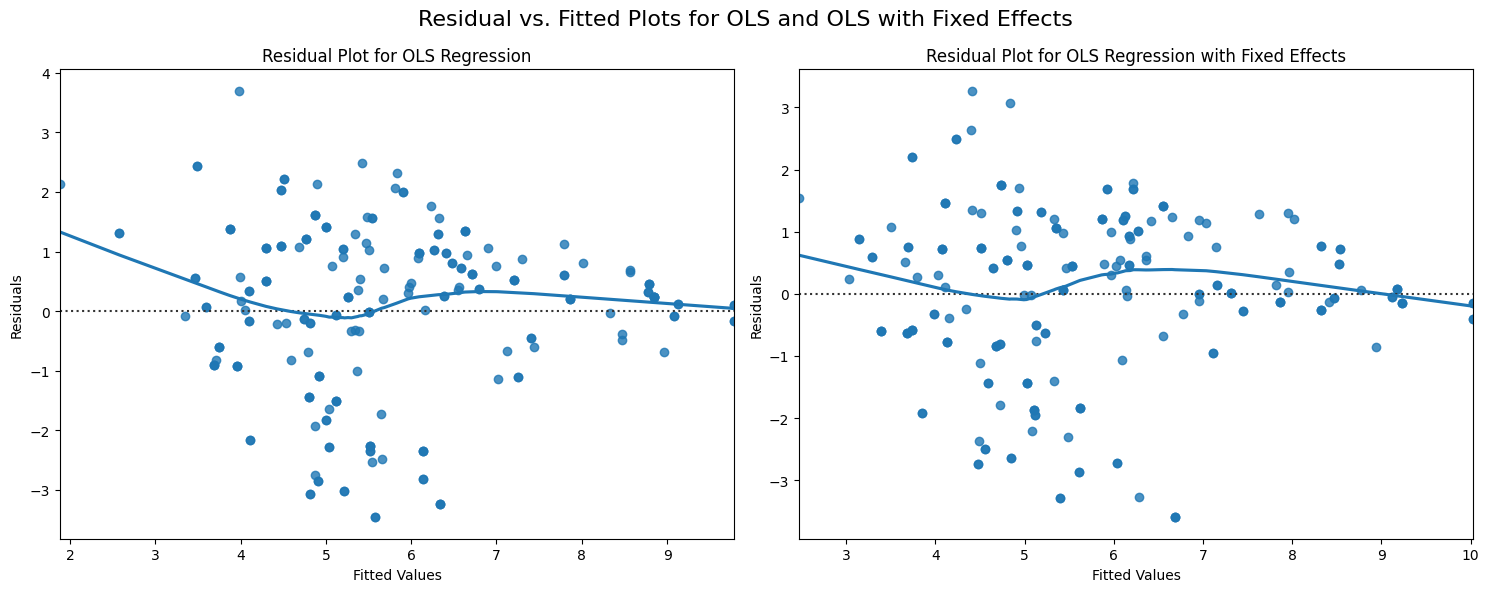

In [368]:
# create 1 x 2 grid for residual plots: one for OLS and one for OLS with fixed effects

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Residual vs. Fitted Plots for OLS and OLS with Fixed Effects', fontsize=16)

# create residual plot for OLS
sns.residplot(x=y_pred_ols, y=residuals, lowess=True, ax=axes[0])
axes[0].set_title('Residual Plot for OLS Regression')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')

# create residual plot for OLS with fixed effects
sns.residplot(x=y_pred_fe, y=residuals_fe, lowess=True, ax=axes[1])
axes[1].set_title('Residual Plot for OLS Regression with Fixed Effects')
axes[1].set_xlabel('Fitted Values')
axes[1].set_ylabel('Residuals')

plt.tight_layout()

The graphs above have quite similar results between our normal OLS and OLS with fixed effects models. As we can see from these two graphs above, normality and homoskedasticity of residuals appear to be violated. The violation of normality is less consequential given our larger sample size and the central limit theorem. Homoskedasticity appears to be significantly violated which does affect our calculation of our analytical standard errors which could lead to inaccurate tests and inference. Our bootstrapped CIs are more robust to this violation, however. Although the residual plot above may appear slightly nonlinear, our analysis above illustrates that there is no significant breaching of nonlinearity. In addition, with high $n$, the violation of homoskedasticity is less consequential on our inference. As we saw in our heatmaps from our EDA, there could be some minor issues with multicollinearity as some predictors have moderately large correlation coefficients with each other (|r| > 0.5). This can be a potential issue as it means our coefficient predictions are less stable and our inference is less reliable. Linearity, from our residuals vs. fitted plots, appears to be generally reasonably followed. There may be a small violation, but this is not really significant (which we also tested for outside of this notebook).

With all of this being said, we believe that our multiple OLS regression is a great baseline model, but we still feel that it would be valuable to do more modeling to make sure that our results are truly robust to these issues of multicollinearity and homoskedasticity. As such, we want to use a random forest regression model as our final model for variable selection. Even though we did not find any significant nonlinearities in our errors, the random forest is still robust to any of these issues of nonlinearity. This is because the splits of a decision tree create piecewise boundaries on there own. In addition, variable importance from permutation tests of a random forest model do not depend at all on any normality or homoskedasticity assumptions. 

Decision trees are also more robust to multicollinearity. Indeed, Genuer et. al (2010), a peer-reviewed paper cited over 3000 times, shows that when engaging in variable selection for interpretation purposes, the addition of highly-correlated variables to already-known important vriables only affected the magnitude -- NOT the order -- of variable importance for the random forest permutation importance statistics. They also show that the optimal way to engage in variable selection for interpretation purposes aligned with our method chosen in our proposal: Construct RF models with different hyperparameter values and choose the RF model with the lowest OOB error rate for interpretation and feature selection. 

There are, however, tradeoffs when using the RF model over the multiple OLS linear regression. The RF model is less interpretable than a linear regression and pretty much only useful for feature selection given that our project is not concerned with prediction. The use of LIME importance may help increase interpretability, but the point stands that linear regression is very easily interpreted. We also are unable to engage in any meaningful inference using this model either. Thus, although the RF model is seen as our ``final model'' for the reasons detailed above, it is not our only model and we will still consider the multiple OLS regression in our discussion of the results.

Citation: Robin Genuer, Jean-Michel Poggi, Christine Tuleau-Malot. Variable selection using Random Forests. Pattern Recognition Letters, Elsevier, 2010, 31 (14), pp.2225-2236.



# 4. Final Model (Random Forest) Pipeline

Given our discussion above, we will now build a pipeline for our random forest regression model. 

A few things about how we set up preprocessing for pipeline:

- We do not need to engage in any feature preprocessing again. We do not need to standardize our variables because decision trees use _thresholds_ rather than _levels_, which means that different scales do not affect our overall fit or our ultimate feature importance values. We will also, based on our results from our baseline model exploration, try adding our wave dummy variables into our analysis given their significance in our model.
- We do not need any specific polynomial or log transformation as decision trees can inherently capture non-linear relationships in the data because its splits create piecewise decision boundaries on its own.

The model selection process will be as follows:

- The hyperparameters that we need to tune are: 
    - We will use MSE as our splitting criteria. This is the main criteria used by most practioners and the only one we learned in class. 
    - Max_features: Sqrt or log2. Sqrt is the method that most long time practicioners use for random forests and log2 is another popular method so we will try both.
    - Number of trees: (1 to 250 with stepsize of 25): We need to figure out how many trees should be fit. Given that our dataset is not huge, we expect a fairly low number of trees need to be fit to best generalize to our data and after that there are diminishing returns. 
    - Complexity: We will tune max_depth, max_leaf_nodes, and min_impurity_decrease (also known as accuracy gain) as our separate measures for limiting complexity. Max_depth and max_leaf_nodes are both classic methods of controlling complexity and differ in how balanced the tree becomes while min_impurity_decrease is a frequently used method for controlling complexity in decision tree regression cases.
        - For now, we will iterate through max depth values between 1 and 25 with stepsize of 2, max leaf nodes values between 1 and 100 with stepsize of 5, and impurity decrease thresholds between 0 and 0.5 (0, 0.0001, 0.001, 0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5). These are subject to change as we work with the model and see results but are good starting points for testing complexity.
    
- To choose our hyperparameters, we will use out-of-bag error. We use this over cross validation since with cross validation there is a leakage of data (every validation has been seen in training by a few decision trees and there is thus some form of leakage). OOB prevents leakage and has a lower computation cost. Even though this means our CV scores can no longer be compared apples-to-apples with our CV scores from our previous models, it should still be able to give us a ballpark estimate for how well our model does compared to the MSE-based evaluations from our previous models.

Once we have chosen the best hyperparameters for our model, we can then engage in feature importance analysis. We can begin by looking at permutation importance which is more robust than built-in MDI importance as discussed in class (MDI usually focuses too much on variables with high cardinality or numerical variables). 

We also will experiment with LIME as a way to measure feature importance because it:
- Provide us with local explanations. In other words, it explains individual predictions by estimating the importance of each feature for a specific data point.
- It allows for greater interpretability -- we can look at why our model gave specific predictions. 
- Having both a global and a local variable importance measure will give us more information regarding the associations between countries' various beliefs and how democratic they are.

Below is a flow chart explaining how we are going about tuning our model:
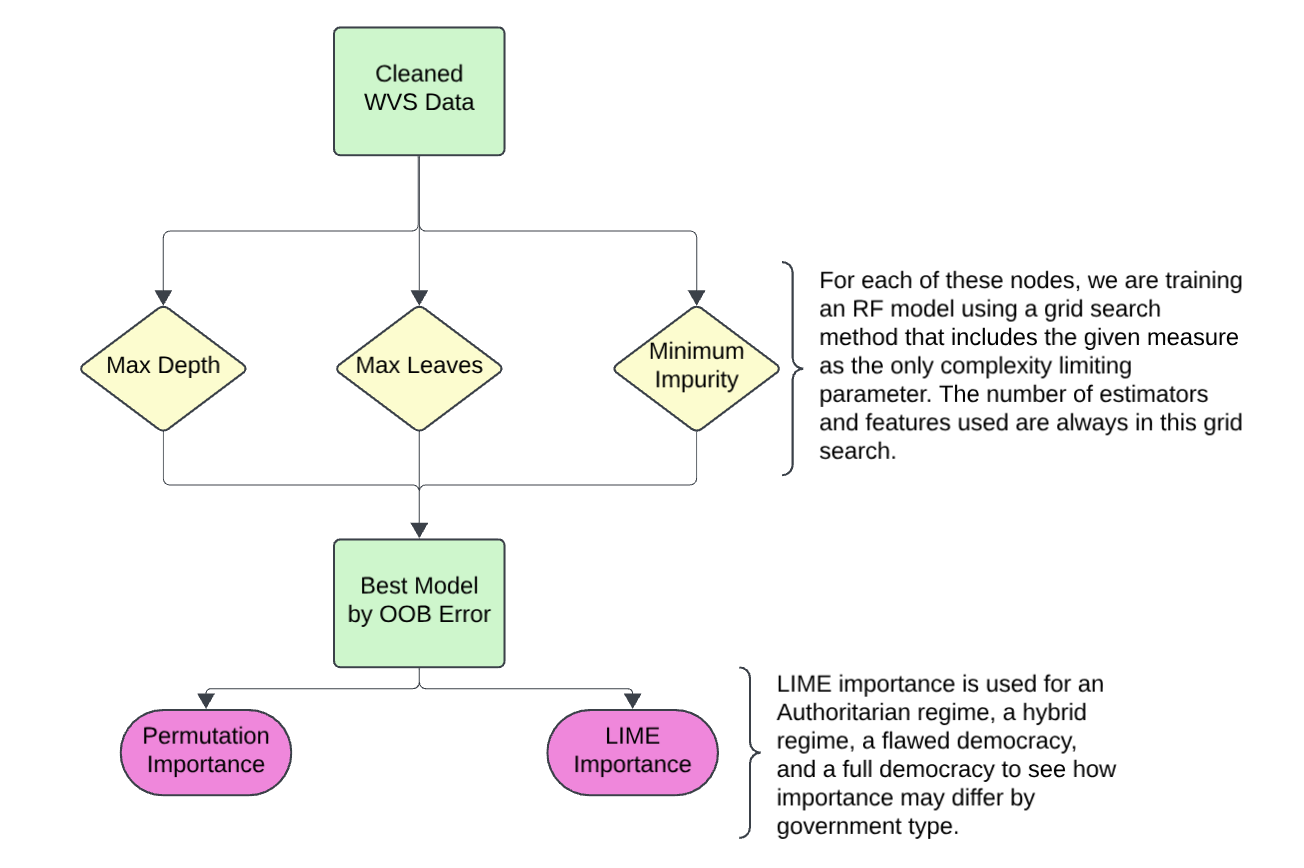

Below is a pipeline that we have created to tune our random forest model using OOB error. To run this pipeline, we would simply build our param grid (using the values we stated earlier), and plug in our data.

In [369]:
"""Function for tuning random forest model using OOB error"""

def tune_random_forest(X, y, params_grid, random_state, preprocessor=None):
    """
    Tune a Random Forest model using OOB error.
    - X: features data
    - y: response variable data
    - params_grid: dictionary of hyperparameters to search over
    - random_state: random seed
    - preprocessor: preprocessor to use in pipeline
    """

    best_params = None
    best_oob_score = 0
    results = []
    # iterate through all possible hyperparameter combos 
    for param in ParameterGrid(params_grid):

        # set up pipeline
        if preprocessor:
            pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', RandomForestRegressor(random_state=random_state, oob_score=True, **param))
            ])
        else:
            pipeline = Pipeline(steps=[
                ('classifier', RandomForestRegressor(random_state=random_state, oob_score=True, **param))
            ])

        # fit model
        pipeline.fit(X, y)

        # get OOB score
        oob_score = pipeline.named_steps['classifier'].oob_score_

        # save results
        results.append({
            'params': param,
            'oob_score': oob_score
        })

        # update best parameters
        if oob_score > best_oob_score:
            best_oob_score = oob_score
            best_params = param
            
    return {'best_params': best_params, 'best_oob_score': best_oob_score, 'results': results}


In [370]:
rf_param_grid_max_depth = {
    'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200, 225, 250],
    'max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25],
    'max_features': ['sqrt', 'log2']
}

# tune random forest model with max depth
rf_tuned_max_depth = tune_random_forest(X_train_full, y_train, rf_param_grid_max_depth, random_state=15)


# get best parameters and OOB score
print("Random Forest Best Parameters (Max Depth):", rf_tuned_max_depth['best_params'])
print("Random Forest Best OOB Score (Max Depth):", rf_tuned_max_depth['best_oob_score'])

rf_param_grid_max_leaf_nodes = {
    'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200, 225, 250],
    'max_leaf_nodes': list(range(2, 100, 5)) + [None],
    'max_features': ['sqrt', 'log2']
}

# tune random forest model with max leaf nodes
rf_tuned_max_leaf_nodes = tune_random_forest(X_train_full, y_train, rf_param_grid_max_leaf_nodes, random_state=15)

# get best parameters and OOB score
print("Random Forest Best Parameters (Max Leaf Nodes):", rf_tuned_max_leaf_nodes['best_params'])
print("Random Forest Best OOB Score (Max Leaf Nodes):", rf_tuned_max_leaf_nodes['best_oob_score'])

rf_param_grid_min_impurity_decrease = {
    'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200, 225, 250],
    'min_impurity_decrease': [0, 0.0001, 0.001, 0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5],
    'max_features': ['sqrt', 'log2']
}

# tune random forest model with min impurity decrease
rf_tuned_min_impurity_decrease = tune_random_forest(X_train_full, y_train, rf_param_grid_min_impurity_decrease, random_state=15)

# get best parameters and OOB score
print("Random Forest Best Parameters (Min Impurity Decrease):", rf_tuned_min_impurity_decrease['best_params'])
print("Random Forest Best OOB Score (Min Impurity Decrease):", rf_tuned_min_impurity_decrease['best_oob_score'])


Random Forest Best Parameters (Max Depth): {'max_depth': 9, 'max_features': 'log2', 'n_estimators': 150}
Random Forest Best OOB Score (Max Depth): 0.8824950292635061
Random Forest Best Parameters (Max Leaf Nodes): {'max_features': 'log2', 'max_leaf_nodes': 97, 'n_estimators': 225}
Random Forest Best OOB Score (Max Leaf Nodes): 0.8852903705073083
Random Forest Best Parameters (Min Impurity Decrease): {'max_features': 'log2', 'min_impurity_decrease': 0.0001, 'n_estimators': 250}
Random Forest Best OOB Score (Min Impurity Decrease): 0.8851402122858164


After running our pipeline, two things are evident: 1. The RF performs significantly better than any of the other models used in terms of our validation scores (an OOB error of below 1 is significantly better than any of our previous models) and 2. the best model is an RF with depth 9, 150 estimators, with log2 number of predictors chosen randomly for each leaf. This further proves our point that RF is likely the best model to use as it appears to perform the best in terms of actual prediction for our data.

In [371]:
# get best model
best_rf = RandomForestRegressor(random_state=15, oob_score=True, n_estimators=150, max_depth = 9, max_features = 'log2')

# fit best model
best_rf.fit(X_train_full, y_train)

# get OOB score
oob_score_rf = best_rf.oob_score_

print("Random Forest OOB Score:", oob_score_rf)

# get train mse
rf_train_predictions = best_rf.predict(X_train_full)

rf_train_mse = mean_squared_error(y_train, rf_train_predictions)

print(f"Random Forest Train MSE: {rf_train_mse:.3f}")



Random Forest OOB Score: 0.8824950292635061
Random Forest Train MSE: 0.101


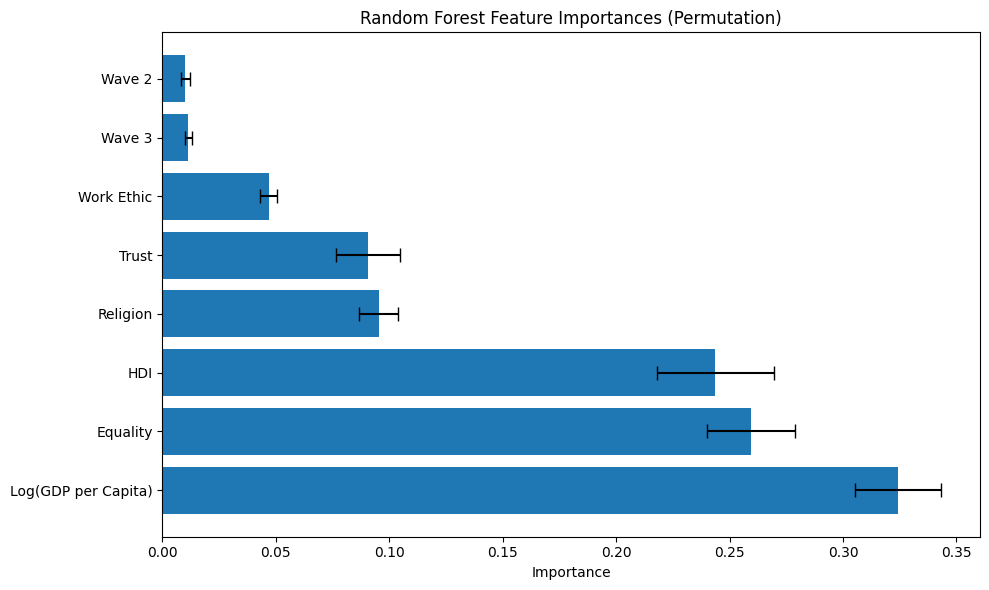

In [372]:
# get permutation importances
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_rf, X_train_full, y_train, n_repeats=10, random_state=15)

perm_imp = pd.DataFrame({
    'feature': X_train_full.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

feature_map_rf = {
    'wave_2.0': 'Wave 2',
    'wave_3.0': 'Wave 3',
    'work_ethic': 'Work Ethic',
    'trust': 'Trust',
    'religion': 'Religion',
    'equality': 'Equality',
    'hdi': 'HDI',
    'log_gdp_per_capita': 'Log(GDP per Capita)'
}


perm_imp['feature'] = perm_imp['feature'].map(feature_map_rf)

# Plot features with error bars
plt.figure(figsize=(10, 6))
plt.barh(range(len(perm_imp)), perm_imp['importance_mean'],
         xerr=perm_imp['importance_std'], capsize=5)
plt.yticks(range(len(perm_imp)), perm_imp['feature'])
plt.title('Random Forest Feature Importances (Permutation)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


We see that based on permutation importance metrics, that our metrics of development appear to be most important. Log(GDP per Capita) and HDI are two of the three most important predictors of democracy. Equality is then the most important value of our four values. Trust and religion appear to have moderate importance (which is different for religion) while work ethic and both of our wave dummies have little predictive value. This is quite interesting as it appears to fully show that economic development is the most important predictor of democracy. Other models from before such as OLS and LASSO showed that these economic development effects are less significant than equality. Moreover, HDI was not close to significant in either of our OLS regressions. 

The differences could be a few reasons. One, regression focuses on linear relationships and direct effects which may not be fully reflective of how strong of a predictor a given variable is especially when its effect may be more nonlienar or complex. Two, a random forest can also consider interactions, redundancy (especially in the context of our HDI and GDP per capita variables -- importance may be spread out between these two variables rather than just put to GDP per capita like in a regression context). Moreover, importance is different in regression than in RF -- regression looks at the expected change in a dependent variable for a unit change in a predictor while permutation importance investigates how much worse predictions become if a given feature has its values randomly shuffled. However, as we see in the graph below, even if we use permutation importance for our best OLS model (OLS with fixed effects), we see that there are still large differences (high importance still on equality and wave dummies but less so on any other value and HDI). This points to more of the difference likely being due to interactions and nonlinear effects (for example, HDI is correlated with Log(GDP per capita) or may show something about a country when log GDP is high leading it to be an important differentiator among certain country subgroups). Religion and trust are also moderately important (and much more important than the permutation importance for the OLS with FE regression shows) which could illustrate that these values may also have certain nonlinear, complex relationships with the response and other features as well as potential predictive power amongst certain country subgroups. 

The lack of significance of the wave dummy suggests that time is not a strong predictor of democracy meaning that changes in values and development better explain the negative trend in democracy over time.

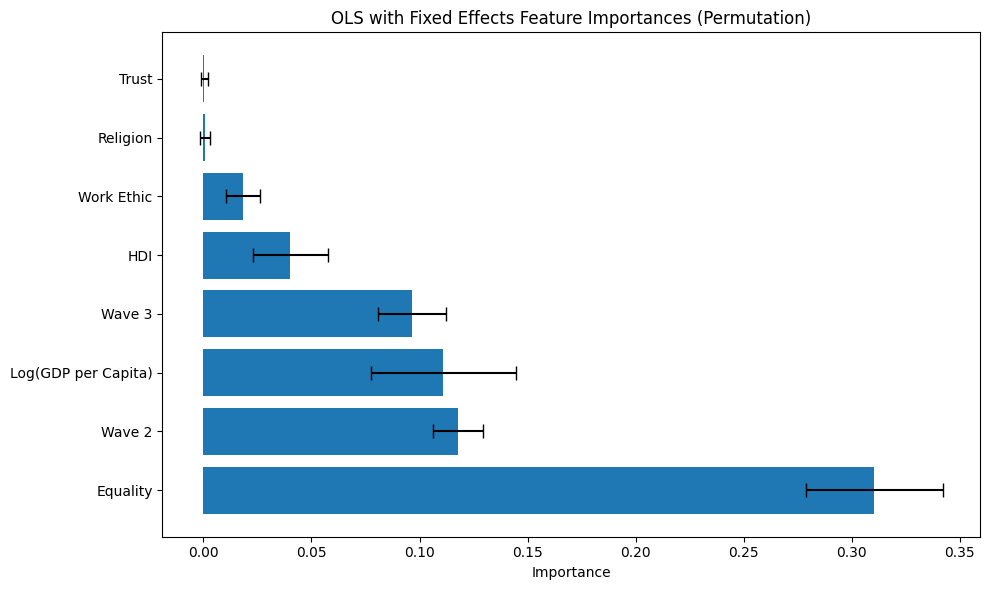

In [373]:
# permutation importance for our OLS with fixed effects model 
perm_importance_fe = permutation_importance(best_pipeline_fe, X_train_full, y_train, n_repeats=10, random_state=15)

perm_imp_fe = pd.DataFrame({
    'feature': X_train_full.columns,
    'importance_mean': perm_importance_fe.importances_mean,
    'importance_std': perm_importance_fe.importances_std
}).sort_values('importance_mean', ascending=False)

perm_imp_fe['feature'] = perm_imp_fe['feature'].map(feature_map_rf)

# Plot features with error bars

plt.figure(figsize=(10, 6))

plt.barh(range(len(perm_imp_fe)), perm_imp_fe['importance_mean'],
            xerr=perm_imp_fe['importance_std'], capsize=5)
plt.yticks(range(len(perm_imp_fe)), perm_imp_fe['feature'])
plt.title('OLS with Fixed Effects Feature Importances (Permutation)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

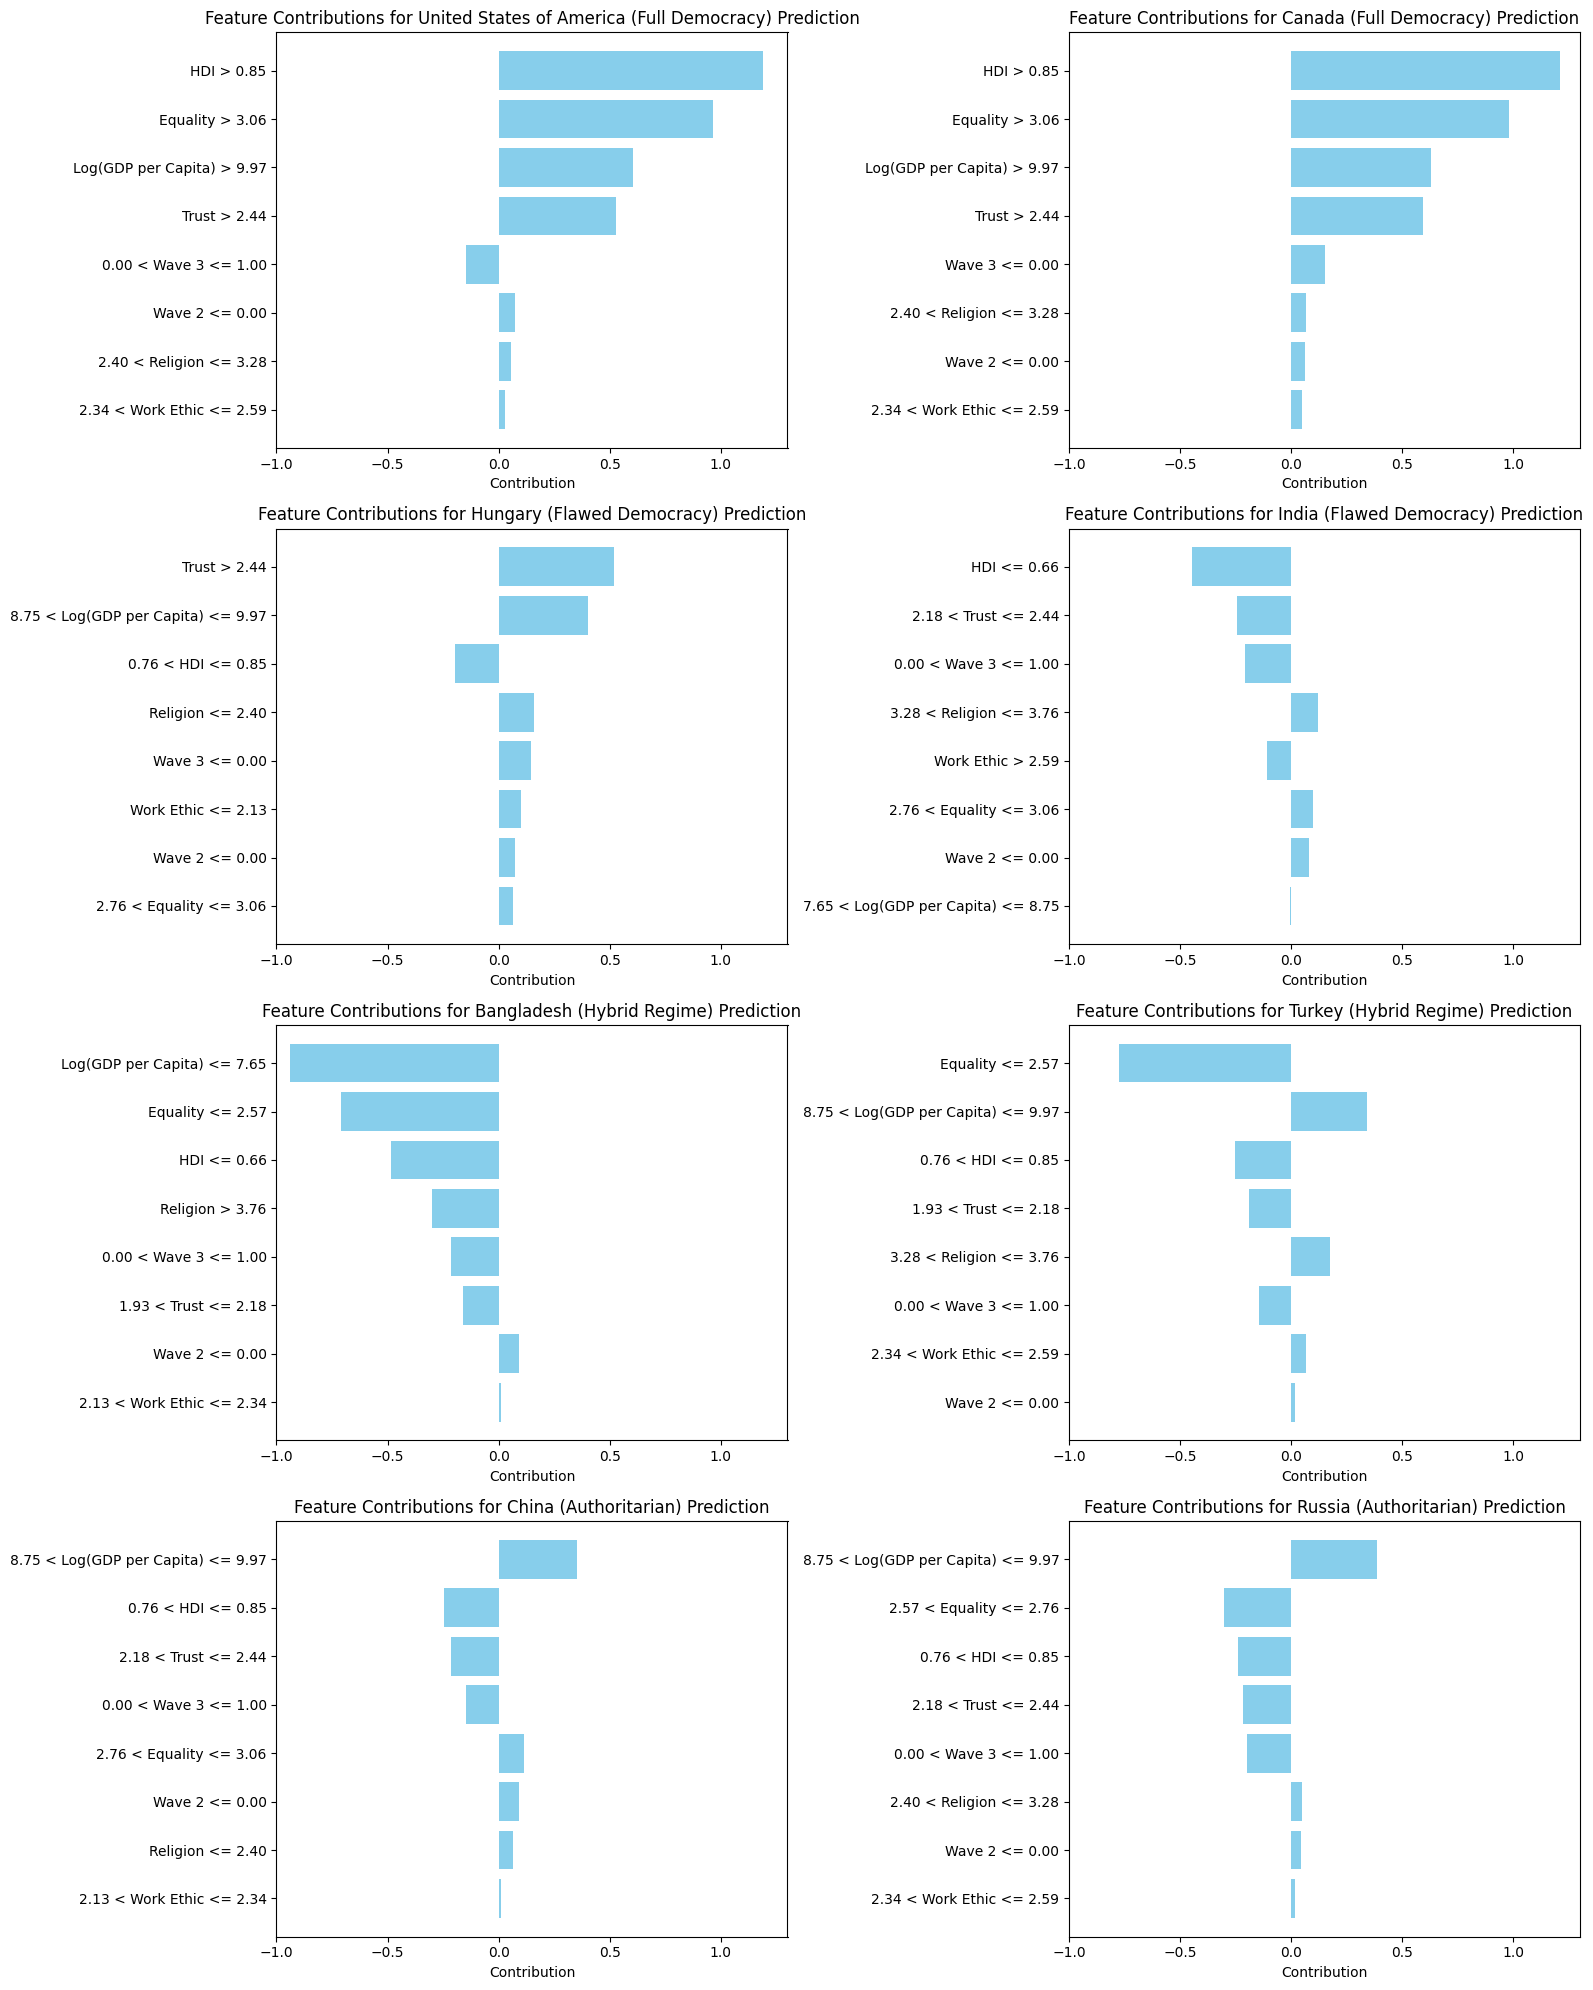

In [374]:
# create explainer
explainer = LimeTabularExplainer(X_train_full.values, 
                                 mode='regression',
                                 feature_names=X_train_full.columns,
                                 random_state=15)

# ignore warnings for this cell
import warnings
warnings.filterwarnings('ignore')

# get idx where Country is 'United States' 
us_idx = X_train_f[X_train_f['Country'] == 'United States of America'].index[0]
canada_idx = X_train_f[X_train_f['Country'] == 'Canada'].index[0]

china_idx = X_train_f[X_train_f['Country'] == 'China'].index[0]
russia_idx = X_train_f[X_train_f['Country'] == 'Russia'].index[0]

hungary_idx = X_train_f[X_train_f['Country'] == 'Hungary'].index[0]
india_idx = X_train_f[X_train_f['Country'] == 'India'].index[0]

bangladesh_idx = X_train_f[X_train_f['Country'] == 'Bangladesh'].index[0]
turkey_idx = X_train_f[X_train_f['Country'] == 'Turkey'].index[0]


# Initialize the 4x2 grid for subplots
fig, axes = plt.subplots(4, 2, figsize=(16, 20))

# Define the countries and their respective indices
countries = [
    ("United States of America (Full Democracy)", us_idx),
    ("Canada (Full Democracy)", canada_idx),
    ("Hungary (Flawed Democracy)", hungary_idx),
    ("India (Flawed Democracy)", india_idx),
    ("Bangladesh (Hybrid Regime)", bangladesh_idx),
    ("Turkey (Hybrid Regime)", turkey_idx),
    ("China (Authoritarian)", china_idx),
    ("Russia (Authoritarian)", russia_idx)
]

def map_feature_name(feature, mapping):
    for key, value in mapping.items():
        if key in feature:  # Check if key is a substring of the feature name
            return feature.replace(key, value)
    return feature  # Return the original feature if no match is found

# Iterate through each country and its corresponding subplot
for i, (country, idx) in enumerate(countries):
    row, col = divmod(i, 2)  # Calculate the row and column for each subplot
    pred = best_rf.predict(X_train_full.loc[[idx]])[0]
    exp = explainer.explain_instance(X_train_full.loc[idx], best_rf.predict, num_features=8)
    
    features = [map_feature_name(x[0], feature_map_rf) for x in exp.as_list()]
    contributions = [x[1] for x in exp.as_list()]
    
    
    # Plot in the appropriate subplot
    axes[row, col].barh(features, contributions, color='skyblue')
    axes[row, col].set_xlabel("Contribution")
    axes[row, col].set_title(f"Feature Contributions for {country} Prediction")
    axes[row, col].invert_yaxis()  # Optional: invert y-axis for better readability
    # make x axis go from -1 to 1.3
    axes[row, col].set_xlim(-1, 1.3)

# Adjust layout
plt.tight_layout()
plt.show()



With this LIME importance figure, we found LIME importance values for countries that are in the four buckets of democracy-level as defined by The Economist. This will help us understand how decisions are made by our random forest across different types of countries.

In general, log GDP per capita and HDI move in the expected directions in terms of their impact (higher levels mean a higher democracy score). They are also typically one of the more important predictors for each of these predictions. Equality also moves in the expected direction and has a high importance across observations. It does appear that within certain predictions, both HDI and log GDP per Capita play a role in our prediction which tells us that both of these predictors may have separate things to tell us (and are not just the same measure of development). 

Work ethic and the wave dummies have little to no contribution across our different observations. The wave dummy does go in the direction of suggesting countries have become less democratic over time.

Trust appears to be positively associated with the democracy index and has moderate importance across our observations. The positive relationship is only untrue for China which means that there may be a different relationship between trust and democracy among certain country types (e.g. Asian countries with a higher degree of collectivism).

Now, let's talk a little about how predictions seem to differ across our government types. As a preface, since we are only looking at two observations per government type, none of these conclusions are set in stone but are instead our best guesses at what may be happening. For full democracies, it appears that equality, development values, and trust make up the bulk of any prediction. 

For flawed democracies, the system is different. Development is not as large in its effect (though still quite important). Trust remains quite important for these countries while the other features are generally much less significant. Interestingly, equality has little predictive power for these flawed democracies which may tell us that equality values around the mean may not tell us as much about a country's democracy (and that values at the extreme might be more distinguishing). 

For hybrid regimes, equality and development dominate the top importances. Low equality scores have a significant negative prediction effect for these countries as well as a relatively lower/higher HDI value. Turkey is interesting in that its high HDI value is a predictor of a lower democracy index. It could be that for countries with high GDP but low equality values, greater development actually predicts worse democracy scores though the reason would be pretty unclear. There appear to be important subgroup dynamics at play that may be worth further exploring.

Lastly, for authoritarian regimes, it appears that HDI also appears to have a negative relationship with the democracy index among these higher GDP per capita countries. The rest of our relationships appear fairly consistent with equality, HDI, trust, and log GDP per capita being important. Interestingly, the Wave 3 dummy has a fairly large effect for China which seems to make sense as China has consistently become less democratic over time under Xi Jing Ping. This is a good sanity check that this RF is taking into account more complex changes over time.

Now, we below engage in analysis of averaging LIME importance absolute values by each government type. This is to try to see if the values that contribute most on an absolute value basis differ by our government types. Obviously, this is not a perfect analysis as it is hard to know exactly which split caused the significance (for example, maybe there are huge importance values for equality in some cases because some countries just have outlier equality values), but it should help us gain a general idea and draw some interesting differences if there are any.

In [375]:
X_train_f['Country'].unique()

# i want index of each country
countries = X_train_f['Country'].unique()

country_indices = {}
for country in countries:
    country_indices[country] = X_train_f[X_train_f['Country'] == country].index[0]


# now, i want to split this dictionary into 4 dictionaries based on government type: full democracy, flawed democracy, hybrid regime, and authoritarian
full_democracies = ["United States of America", 'Canada', 'Sweden', 'Netherlands', 'Australia', 'New Zealand', 'Uruguay', 'Great Britain', 'Finland', 'South Korea', 'Spain', 'Japan', 'France', 'Norway', 'Switzerland', 'Greece', 'Germany']

flawed_democracies = ['Hungary', 'India', 'Czechia', 'Romania', 'Ghana', 'Trinidad and Tobago', 'Argentina', 'Malaysia', 'South Africa', 'Slovenia', 'Serbia', 'Colombia', 'Slovakia', 'Cyprus', 'Moldova', 'Mongolia', 'Thailand', 'Italy', 'Estonia', 'Poland', 'Brazil', 'Indonesia', 'Bulgaria', 'Singapore', 'Philippines', 'Chile']

hybrid_regimes = ['Bangladesh', 'Turkey', 'Hong Kong SAR', 'Mexico', 'Armenia', 'Kenya', 'Ecuador', 'Bolivia', 'Tunisia', 'Zambia', 'Nigeria', 'Georgia', 'Peru', 'Guatemala', 'Ukraine']

authoritarian_regimes = ['China', 'Russia', 'Rwanda', 'Jordan', 'Kyrgyzstan', 'Burkina Faso', 'Kuwait', 'Azerbaijan', 'Algeria', 'Qatar', 'Haiti', 'Vietnam', 'Iraq', 'Lebanon', 'Venezuela', 'Palestine', 'Uzbekistan', 'Tajikistan', 'Ethiopia', 'Iran', 'Yemen', 'Myanmar', 'Zimbabwe', 'Kazakhstan', 'Nicaragua', 'Libya', 'Pakistan', 'Egypt', 'Belarus', 'Mali']



In [384]:
import re
import pandas as pd

full_democracy_indices = {}
flawed_democracy_indices = {}
hybrid_regime_indices = {}
authoritarian_regime_indices = {}

for country, index in country_indices.items():
    if country in full_democracies:
        full_democracy_indices[country] = index
    elif country in flawed_democracies:
        flawed_democracy_indices[country] = index
    elif country in hybrid_regimes:
        hybrid_regime_indices[country] = index
    elif country in authoritarian_regimes:
        authoritarian_regime_indices[country] = index

# Combine regime type dictionaries into a single mapping of index to regime
regime_group_mapping = {}
for country, idx in full_democracy_indices.items():
    regime_group_mapping[idx] = "Full Democracy"
for country, idx in flawed_democracy_indices.items():
    regime_group_mapping[idx] = "Flawed Democracy"
for country, idx in hybrid_regime_indices.items():
    regime_group_mapping[idx] = "Hybrid Regime"
for country, idx in authoritarian_regime_indices.items():
    regime_group_mapping[idx] = "Authoritarian Regime"

# Initialize a dictionary to store contributions by regime and feature
regime_contributions = {}

def normalize_feature_name(feature):
    """
    Normalize the feature name by splitting by spaces and keeping only parts with alphabetical characters.
    """
    # Split the feature string by spaces
    parts = feature.split()
    # Keep only parts that have at least one alphabetical character
    for part in parts:
        if any(char.isalpha() for char in part):
            return part
    # Fallback to the original feature name if no alphabetical part is found
    return feature

# Iterate over all observations
for idx in X_train_full.index:
    # Get the regime group for the current observation
    regime_group = regime_group_mapping.get(idx, None)  # Handle missing indices gracefully
    if regime_group is None:
        continue  # Skip if the index doesn't belong to a defined regime group
    
    # Get prediction and explanation
    pred = best_rf.predict(X_train_full.loc[[idx]])[0]
    exp = explainer.explain_instance(X_train_full.loc[idx], best_rf.predict, num_features=8)
    
    # Extract features and contributions
    features = [map_feature_name(x[0], feature_map_rf) for x in exp.as_list()]
    contributions = [x[1] for x in exp.as_list()]
    
    # Normalize feature names and aggregate by regime group
    if regime_group not in regime_contributions:
        regime_contributions[regime_group] = {}
    
    for feature, contribution in zip(features, contributions):
        normalized_feature = normalize_feature_name(feature)
        if normalized_feature not in regime_contributions[regime_group]:
            regime_contributions[regime_group][normalized_feature] = []
        regime_contributions[regime_group][normalized_feature].append(abs(contribution))

# Calculate average absolute contributions for each feature within each regime group
regime_average_contributions = {
    regime: {
        feature: sum(values) / len(values)
        for feature, values in feature_contributions.items()
    }
    for regime, feature_contributions in regime_contributions.items()
}

# Convert the results to a DataFrame for easier analysis
result_df = pd.DataFrame.from_dict(regime_average_contributions, orient="index").reset_index()
result_df.rename(columns={"index": "Regime Group"}, inplace=True)

# normalize values within each row -- divide by sum of all values in row
result_df.iloc[:, 1:] = result_df.iloc[:, 1:].div(result_df.iloc[:, 1:].sum(axis=1), axis=0)


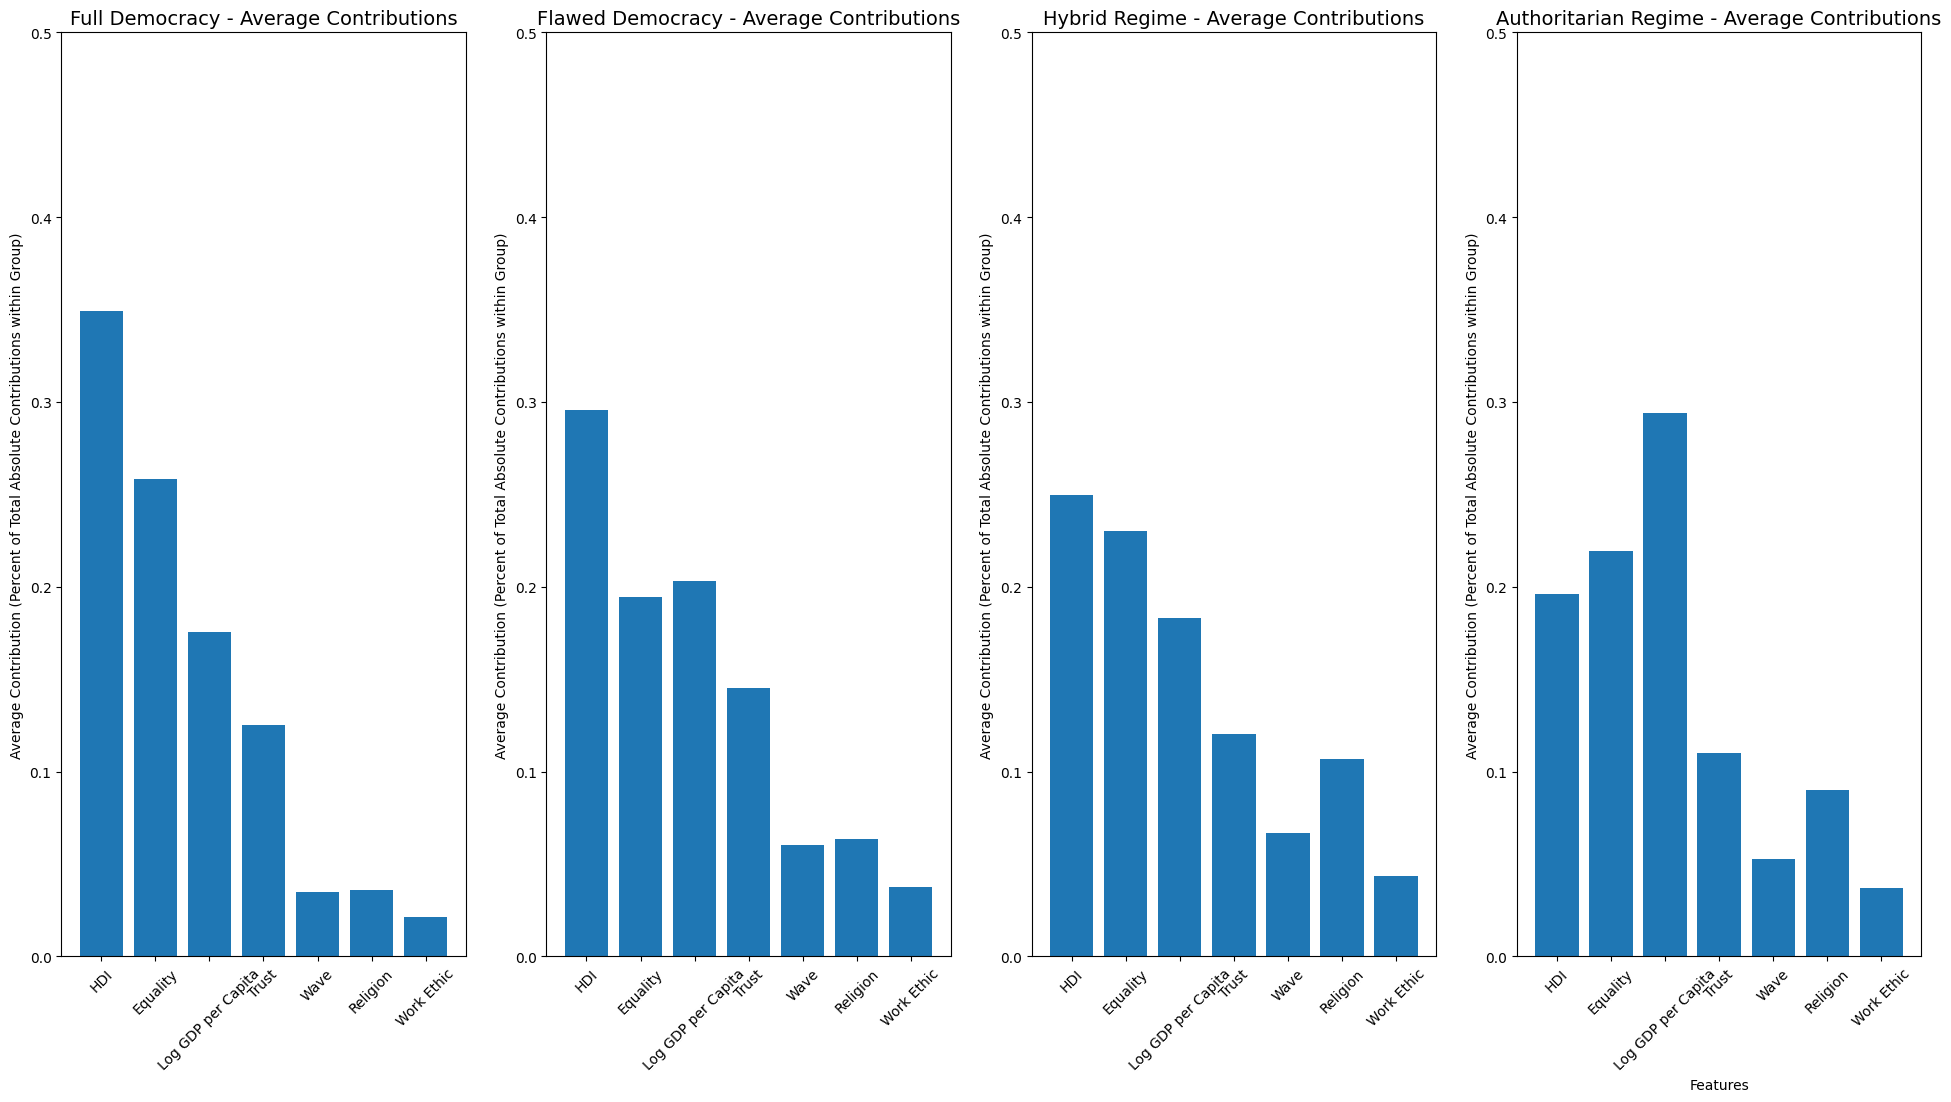

In [387]:
# rename log(GDP to GDP per Capita
result_df.rename(columns={'Log(GDP': 'Log GDP per Capita', 'Work': 'Work Ethic'}, inplace=True)


# Features to plot
features = ['HDI', 'Equality', 'Log GDP per Capita', 'Trust', 'Wave', 'Religion', 'Work Ethic']

# Create a 4x1 grid of subplots
fig, axes = plt.subplots(1, 4, figsize=(24, 12), sharex=True)

# Loop over the indices of the DataFrame
for i in range(len(result_df)):
    ax = axes[i]
    # Extract the row data for the current regime group
    regime_group = result_df.iloc[i, 0]  # First column is the regime group name
    values = result_df.iloc[i, 1:]      # Remaining columns are the feature values
    
    # Create a bar plot
    ax.bar(features, values)
    
    # Set titles and labels
    ax.set_title(f"{regime_group} - Average Contributions", fontsize=14)
    ax.set_ylabel("Average Contribution (Percent of Total Absolute Contributions within Group)")
    if i == len(result_df) - 1:  # Only add x-label to the last subplot
        ax.set_xlabel("Features")
    ax.set_xticks(range(len(features)))
    ax.set_xticklabels(features, rotation=45)
    # make y axis go from 0 to 1.2
    ax.set_ylim(0, 0.5)


We see as the country becomes less and less democratic, the important values change. As the country becomes less democratic, HDI matters less for differentiation and log GDP per capita generally matters more (except in hybrid regimes). This is interesting as it suggests that a more direct measure of development is more significantly associated with democracy for less democratic regimes than a holistic measure. It is unclear why this may be the case. In general, equality, log GDP per capita, and HDI still are the three strongest predictors across all regime types.

Religion is more important of a predictor for less democratic regimes which is quite interesting as well. It could be that among poorer countries with lower equality scores, religion can play a key role in telling us if a country is less democratic or not (with less democratic countries more likely being religious -- e.g. a theocracy).

Ultimately, this analysis shows us that the importance of a feature can depend on what type of observation we are looking at meaning there are different, complex relationships among different types of countries which could warrant further exploration and analysis.

# 5. Model Evaluation and Comparison

### Generating Test Statistics

In [379]:
# Normal OLS model
ols_predictions = ols_pipeline.predict(X_test)

ols_mse = mean_squared_error(y_test, ols_predictions)

print(f"OLS Test MSE: {ols_mse:.3f}")

ols_r2 = r2_score(y_test, ols_predictions)

print(f"OLS Test R-squared: {ols_r2:.3f} \n")


# LASSO model
lasso_predictions = lasso_cv.predict(X_test)

lasso_mse = mean_squared_error(y_test, lasso_predictions)

print(f"LASSO Test MSE: {lasso_mse:.3f}")

lasso_r2 = r2_score(y_test, lasso_predictions)

print(f"LASSO Test R-squared: {lasso_r2:.3f} \n")

# OLS Fixed Effects
X_test_full = pd.concat([
    X_test,
    pd.get_dummies(X_test_f['wave'], prefix='wave', drop_first=True, dtype=int)
], axis=1)

y_pred_fe_test = best_pipeline_fe.predict(X_test_full)

mse_fe_test = mean_squared_error(y_test, y_pred_fe_test)

print(f"Test MSE of Fixed Effects model: {mse_fe_test:.3f}")

r2_fe_test = r2_score(y_test, y_pred_fe_test)

print(f"Test R-squared of Fixed Effects model: {r2_fe_test:.3f} \n")


# Random Forest
rf_predictions = best_rf.predict(X_test_full)

rf_mse = mean_squared_error(y_test, rf_predictions)

print(f"Random Forest Test MSE: {rf_mse:.3f}")

rf_r2 = r2_score(y_test, rf_predictions)

print(f"Random Forest Test R-squared: {rf_r2:.3f}")


OLS Test MSE: 1.620
OLS Test R-squared: 0.589 

LASSO Test MSE: 1.599
LASSO Test R-squared: 0.595 

Test MSE of Fixed Effects model: 1.246
Test R-squared of Fixed Effects model: 0.684 

Random Forest Test MSE: 0.506
Random Forest Test R-squared: 0.872


As expected, the random forest performs by far the best on our unseen test data. The other models perform quite well on the test data as well which tells us that these models were not overfit and generalized pretty well to unseen data. 

The general important conclusion from this strong prediction on our test data is that the conclusions we have drawn from our models are generally reliable and not specific to the training data we looked at given the generalizability of our models.

In [380]:
# create a dataframe with each model's train mse, cv mse, train r-squared, test mse, and test r-squared

model_results = pd.DataFrame({
    'Model': ['OLS', 'LASSO', 'OLS with Fixed Effects', 'Random Forest'],
    'Train MSE': [train_mse, lasso_train_mse, mse_fe, rf_train_mse],
    'CV MSE or OOB Error': [mean_mse, -lasso_cv.best_score_, cv_mse_fe, -rf_tuned_max_depth['best_oob_score']],
    'Train R-squared': [ols_r2, lasso_r2, r2_fe, None],
    'Test MSE': [ols_mse, lasso_mse, mse_fe_test, rf_mse],
    'Test R-squared': [ols_r2, lasso_r2, r2_fe_test, rf_r2],
    'Best Parameters': [None, lasso_cv.best_params_, None, rf_tuned_max_depth['best_params']],
    'Most Significant Features': [
        'Equality, Trust (Almost), Log GDP per Capita (Almost)', 
        'Equality, Log GDP per Capita, HDI', 
        'Equality, Wave Dummies, Log GDP per Capita (Almost), Work Ethic (Almost)',
        'Log GDP per Capita, Equality, HDI'
        ]  
})

display(model_results)



,Model,Train MSE,CV MSE or OOB Error,Train R-squared,Test MSE,Test R-squared,Best Parameters,Most Significant Features
0,OLS,1.982977,2.146129,0.589159,1.620361,0.589159,None,"Equality, Trust (Almost), Log GDP per Capita (..."
1,LASSO,1.989398,2.110141,0.594653,1.598690,0.594653,{'regressor__alpha': 0.04281332398719394},"Equality, Log GDP per Capita, HDI"
2,OLS with Fixed Effects,1.783255,1.976193,0.604309,1.245588,0.684182,None,"Equality, Wave Dummies, Log GDP per Capita (Al..."
3,Random Forest,0.100682,-0.882495,NaN,0.505937,0.871720,"{'max_depth': 9, 'max_features': 'log2', 'n_es...","Log GDP per Capita, Equality, HDI"


## Conclusion

Based on our analysis above, we have uncovered several key insights about the relationship between cultural values, development metrics, and democracy levels across nations. Our analysis reveals several key findings about the factors and features than build successful democracies. 

First, economic and human development development --- unsurprisingly --- are critical.  Log(GDP per capita) and HDI consistently appeared as top predictors in our random forest model, though their relative importance and directional effects varied across different regime types.

Second, among cultural values, equality was by far the most significant predictor, followed by moderate effects from trust and religion. This hierarchy of importance remained relatively consistent across different analytical approaches, though the random forest model revealed that these relationships are often non-linear and context-dependent. For instance, equality's predictive power varied considerably between full democracies and flawed democracies, suggesting threshold effects in how egalitarian values relate to democratic institutions.

Third, our analysis revealed distinct patterns in how predictors operate across different regime types. For example, religion became a more important predictor in less democratic regimes, while HDI's influence decreased. These findings suggest that the path to democracy may not be uniform across all nations, but rather depends on the interplay of multiple factors within specific contexts.

These findings have important implications for understanding democratic development. Cultural values, particularly those relating to equality and trust, play significant roles that vary based on a country's context and development stage. Future research could benefit from exploring these relationships more deeply, particularly focusing on the threshold effects and interaction patterns identified by our models. Additionally, investigating why certain predictors like HDI show different relationships across regime types could provide valuable insights into the mechanisms of democratic development and decay.


# 6. Appendix

### WVS Question Categories

- Work Ethic
    - A005: Important in life: Work
    - E040: Hard work brings success
    - A030: Important child qualities: Hard work
    - A104:	Active/inactive membership of professional organization

- Trust
    - A165	Most people can be trusted
    - G007_18_B	Trust: Your neighborhood (B)
    - G007_33_B	Trust: People you know personally (B)
    - G007_34_B	Trust: People you meet for the first time (B)
    - G007_35_B	Trust: People of another religion (B)
    - G007_36_B	Trust: People of another nationality (B)

- Equality
    - Gender
        - D078	Men make better business executives than women do
        - D059	Men make better political leaders than women do
        - C001	Jobs scarce: Men should have more right to a job than women (3 categories)
        - E233	Democracy: Women have the same rights as men.
        - F199	Justifiable: For a man to beat his wife
    - General Tolerance
        - A124_02 Neighbours: People of a different race
        - A124_06	Neighbours: Immigrants/foreign workers
        - A105	Active/Inactive membership of charitable/humanitarian organization
        - E124	Respect for individual human rights nowadays
        - E069_40	Confidence: Charitable or humanitarian organizations
        - C002	Jobs scarce: Employers should give priority to (nation) people than immigrants (3 categories)

- Religion
    - Involvement
        - A040: Important child qualities: religious faith
        - A098: Active/Inactive membership of church or religious organization
        - E069_01	Confidence: Churches
        - F028	How often do you attend religious services
        - F028B	How often to you pray
        - F034	Religious person
        - F050	Believe in: God
        - F063	How important is God in your life
    - Extremism
        - F203	The only acceptable religion is my religion
        - F202	Whenever science and religion conflict, religion is always right
        - E220	We depend too much on science and not enough on faith